In [23]:
from typing import List
import argparse
import csv
import os
import time
from math import radians, cos, sin, asin, sqrt
import numpy as np
import math
import matplotlib.pyplot as plt


In [24]:

class Station:
    def __init__(self, id, name, position):
        self.id = id
        self.name = name
        self.position = position
        self.links = set()

    def get_distance(self, other_station):
        lat1, lon1 = self.position
        lat2, lon2 = other_station.position
        return math.sqrt((lat1 - lat2) ** 2 + (lon1 - lon2) ** 2)

    def neighbors(self):
        return self.links
    
def build_data():
    """
    builds the 'map' by reading the data files
    Returns:
        station(dict[str, Station]): A mapping between station names and station objects of the name
        underground_lines(dict[str, dict]): A mapping between underground lines name and a dictionary containing relevant
                                            information about underground lines
    """
    stations = {}
    underground_lines = {}
    rootdir = os.getcwd()
    r = csv.reader(open(os.path.join(rootdir, 'london/underground_stations.csv')))
    next(r)  # jump the first line
    for record in r:
        id = int(record[0])
        lat = float(record[1])
        lon = float(record[2])
        name = record[3]
        stations[id] = Station(id, name, (lat, lon))

    r = csv.reader(open(os.path.join(rootdir, 'london/underground_routes.csv')))
    next(r)  # jump the first line
    for id1, id2, lineNumber in r:
        id1 = int(id1)
        id2 = int(id2)
        stations[id1].links.add(stations[id2])
        stations[id2].links.add(stations[id1])
        lineNumber = int(lineNumber)
        if lineNumber not in underground_lines:
            underground_lines[lineNumber] = {'lat': [stations[id1].position[0], stations[id2].position[0], None],
                                             'lon': [stations[id1].position[1], stations[id2].position[1], None],
                                             'stations': {stations[id1].name, stations[id2].name}}
        else:
            underground_lines[lineNumber]['lat'].extend([stations[id1].position[0], stations[id2].position[0], None])
            underground_lines[lineNumber]['lon'].extend([stations[id1].position[1], stations[id2].position[1], None])
            underground_lines[lineNumber]['stations'].add(stations[id1].name)
            underground_lines[lineNumber]['stations'].add(stations[id2].name)
    r = csv.reader(open(os.path.join(rootdir, 'london/underground_lines.csv')))
    next(r) # jump the first line
    for lineNumber, name, colour, stripe in r:
        lineNumber = int(lineNumber)
        underground_lines[lineNumber]['name'] = name
        underground_lines[lineNumber]['colour'] = colour.upper()
        underground_lines[lineNumber]['stripe'] = stripe
    stations = {v.name: v for k, v in stations.items()}
    underground_lines = {v['name']: v for k, v in underground_lines.items()}
    return stations, underground_lines

# 启发函数

In [7]:
def euclidean_distance(station_a, station_b):
    ax, ay = station_a.position
    bx, by = station_b.position
    return math.sqrt((ax - bx) ** 2 + (ay - by) ** 2)

def manhattan_distance(station_a, station_b):
    ax, ay = station_a.position
    bx, by = station_b.position
    return abs(ax - bx) + abs(ay - by)

def simple_distance(station_a, station_b):
    ax, ay = station_a.position
    bx, by = station_b.position
    return max(abs(ax - bx), abs(ay - by))

def cosine_similarity_distance(station_a, station_b):
    (lat_a, lon_a), (lat_b, lon_b) = station_a.position, station_b.position
    vector_a = np.array([lat_a, lon_a])
    vector_b = np.array([lat_b, lon_b])
    cosine_similarity = np.dot(vector_a, vector_b) / (np.linalg.norm(vector_a) * np.linalg.norm(vector_b))
    # Convert cosine similarity to a distance measure
    return 1 - cosine_similarity

def haversine_distance(station_a, station_b):
    lat1, lon1 = station_a.position
    lat2, lon2 = station_b.position
    # 将十进制度数转换为弧度
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    # 计算经纬度差值
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    # 哈弗辛公式
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # 地球平均半径，单位为公里
    return c * r

# 寻路算法

In [8]:
def astar_get_path(start_station_name: str, end_station_name: str, map: dict[str, Station], heuristic_func) -> List[str]:
    open_set = set([start_station_name])
    g_score = {station: float('infinity') for station in map}
    g_score[start_station_name] = 0

    # 初始化 f_score 字典
    f_score = {station: float('infinity') for station in map}
    f_score[start_station_name] = heuristic_func(map[start_station_name], map[end_station_name])

    path = {start_station_name: None}

    while open_set:
        current_station = min(open_set, key=lambda station: f_score[station])
        if current_station == end_station_name:
            break

        open_set.remove(current_station)
        for neighbor in map[current_station].neighbors():
            tentative_g_score = g_score[current_station] + map[current_station].get_distance(neighbor)
            if tentative_g_score < g_score[neighbor.name]:
                path[neighbor.name] = current_station
                g_score[neighbor.name] = tentative_g_score
                f_score[neighbor.name] = tentative_g_score + heuristic_func(map[neighbor.name], map[end_station_name])
                if neighbor.name not in open_set:
                    open_set.add(neighbor.name)

    # 从终点站回溯到起始站
    current = end_station_name
    shortest_path = []
    while current is not None:
        shortest_path.append(current)
        current = path[current]
    return shortest_path[::-1]  # 反转路径


import heapq

def dijkstra_get_path(start_station_name: str, end_station_name: str, map: dict[str, Station]) -> List[str]:
    distances = {station: float('infinity') for station in map}
    distances[start_station_name] = 0
    priority_queue = [(0, start_station_name)]
    path = {start_station_name: None}

    while priority_queue:
        current_distance, current_station = heapq.heappop(priority_queue)
        if current_station == end_station_name:
            break

        for neighbor in map[current_station].neighbors():
            distance = current_distance + map[current_station].get_distance(neighbor)
            if distance < distances[neighbor.name]:
                distances[neighbor.name] = distance
                heapq.heappush(priority_queue, (distance, neighbor.name))
                path[neighbor.name] = current_station

    # Backtrack from end_station_name to start_station_name
    current = end_station_name
    shortest_path = []
    while current is not None:
        shortest_path.append(current)
        current = path[current]
    return shortest_path[::-1]  # Reverse the path

def dfs_get_path(start_station_name: str, end_station_name: str, map: dict[str, Station]) -> List[str]:
    stack = [(start_station_name, [start_station_name])]
    visited = set()

    while stack:
        current_station, path = stack.pop()

        if current_station == end_station_name:
            return path

        if current_station not in visited:
            visited.add(current_station)
            neighbors = map[current_station].neighbors()

            # Sort neighbors based on a heuristic function
            sorted_neighbors = sorted(neighbors, key=lambda neighbor: euclidean_distance(map[neighbor.name], map[end_station_name]))

            for neighbor in sorted_neighbors:
                stack.append((neighbor.name, path + [neighbor.name]))

    return []

def greedy_best_first_get_path(start_station_name: str, end_station_name: str, map: dict[str, Station]) -> List[str]:
    open_set = set([start_station_name])
    path = [start_station_name]

    while open_set:
        current_station = min(open_set, key=lambda station: euclidean_distance(map[station], map[end_station_name]))
        if current_station == end_station_name:
            return path

        open_set.remove(current_station)
        neighbors = map[current_station].neighbors()

        # 找到与目标节点最接近的邻居节点
        nearest_neighbor = min(neighbors, key=lambda neighbor: euclidean_distance(map[neighbor.name], map[end_station_name]))

        # 将最接近的邻居节点添加到路径和开放集合中
        path.append(nearest_neighbor.name)
        open_set.add(nearest_neighbor.name)

    return []
#此算法不适合规定了路线的

from collections import deque

def bfs_get_path(start_station_name: str, end_station_name: str, map: dict[str, Station]) -> List[str]:
    queue = deque([(start_station_name, [start_station_name])])  # 使用队列存储待探索的节点和路径
    visited = set()

    while queue:
        current_station, path = queue.popleft()

        if current_station == end_station_name:
            return path

        if current_station not in visited:
            visited.add(current_station)

            neighbors = map[current_station].neighbors()
            for neighbor in neighbors:
                if neighbor.name not in visited:
                    queue.append((neighbor.name, path + [neighbor.name]))

    return []
   
stations, underground_lines = build_data()

# 计算路程

In [11]:
def calculate_total_distance(path: List[str], map: dict[str, Station]) -> float:
    total_distance = 0.0
    for i in range(len(path) - 1):
        station_a = map[path[i]]
        station_b = map[path[i + 1]]
        total_distance += euclidean_distance(station_a, station_b)

    return total_distance


# 生成随机站点

In [21]:
import random

def generate_random_station_names(stations):
    station_names = list(stations.keys())
    station1_name = random.choice(station_names)
    station2_name = random.choice(station_names)
    
    while station1_name == station2_name:
        station2_name = random.choice(station_names)
        
    return station1_name, station2_name

# 使用临近站点："Acton Town =>Turnham Green"

In [12]:
# A* with Euclidean Distance
start_time = time.time()
path_astar_euclidean = astar_get_path("Acton Town", "Turnham Green", stations, euclidean_distance)
end_time = time.time()
distance_astar_euclidean = calculate_total_distance(path_astar_euclidean, stations)
print("A* Euclidean Path:", path_astar_euclidean)
print("A* Euclidean Execution Time:", end_time - start_time, "seconds")
print("A* Euclidean Path Length:", distance_astar_euclidean)

# A* with Manhattan Distance
start_time = time.time()
path_astar_manhattan = astar_get_path("Acton Town", "Turnham Green", stations, manhattan_distance)
end_time = time.time()
distance_astar_manhattan = calculate_total_distance(path_astar_manhattan, stations)
print("A* Manhattan Path:", path_astar_manhattan)
print("A* Manhattan Execution Time:", end_time - start_time, "seconds")
print("A* Manhattan Path Length:", distance_astar_manhattan)

# A* with Simple Distance
start_time = time.time()
path_astar_simple = astar_get_path("Acton Town", "Turnham Green", stations, simple_distance)
end_time = time.time()
distance_astar_simple = calculate_total_distance(path_astar_simple, stations)
print("A* Simple Path:", path_astar_simple)
print("A* Simple Execution Time:", end_time - start_time, "seconds")
print("A* Simple Path Length:", distance_astar_simple)

# A* with Cosine Similarity Distance
start_time = time.time()
path_astar_cosine = astar_get_path("Acton Town", "Turnham Green", stations, cosine_similarity_distance)
end_time = time.time()
distance_astar_cosine = calculate_total_distance(path_astar_cosine, stations)
print("A* Cosine Path:", path_astar_cosine)
print("A* Cosine Execution Time:", end_time - start_time, "seconds")
print("A* Cosine Path Length:", distance_astar_cosine)

# A* with Haversine Distance
start_time = time.time()
path_astar_haversine = astar_get_path("Acton Town", "Turnham Green", stations, haversine_distance)
end_time = time.time()
distance_astar_haversine = calculate_total_distance(path_astar_haversine, stations)
print("A* Haversine Path:", path_astar_haversine)
print("A* Haversine Execution Time:", end_time - start_time, "seconds")
print("A* Haversine Path Length:", distance_astar_haversine)

# Dijkstra's Algorithm
start_time = time.time()
path_dijkstra = dijkstra_get_path("Acton Town", "Turnham Green", stations)
end_time = time.time()
distance_dijkstra = calculate_total_distance(path_dijkstra, stations)
print("Dijkstra's Path:", path_dijkstra)
print("Dijkstra's Execution Time:", end_time - start_time, "seconds")
print("Dijkstra's Path Length:", distance_dijkstra)

# Depth-First Search (DFS)
start_time = time.time()
path_dfs = dfs_get_path("Acton Town", "Turnham Green", stations)
end_time = time.time()
distance_dfs = calculate_total_distance(path_dfs, stations)
print("DFS Path:", path_dfs)
print("DFS Execution Time:", end_time - start_time, "seconds")
print("DFS Path Length:", distance_dfs)

# Breadth-First Search (BFS)
start_time = time.time()
path_bfs = bfs_get_path("Acton Town", "Turnham Green", stations)
end_time = time.time()
distance_bfs = calculate_total_distance(path_bfs, stations)
print("BFS Path:", path_bfs)
print("BFS Execution Time:", end_time - start_time, "seconds")
print("BFS Path Length:", distance_bfs)

# Greedy Best-First Search
start_time = time.time()
path_greedy = greedy_best_first_get_path("Acton Town", "Turnham Green", stations)
end_time = time.time()
distance_greedy = calculate_total_distance(path_greedy, stations)
print("Greedy Best-First Path:", path_greedy)
print("Greedy Best-First Execution Time:", end_time - start_time, "seconds")
print("Greedy Best-First Path Length:", distance_greedy)

A* Euclidean Path: ['Acton Town', 'Turnham Green']
A* Euclidean Execution Time: 0.0006544589996337891 seconds
A* Euclidean Path Length: 0.026541476974727668
A* Manhattan Path: ['Acton Town', 'Turnham Green']
A* Manhattan Execution Time: 0.0005536079406738281 seconds
A* Manhattan Path Length: 0.026541476974727668
A* Simple Path: ['Acton Town', 'Turnham Green']
A* Simple Execution Time: 0.0005583763122558594 seconds
A* Simple Path Length: 0.026541476974727668
A* Cosine Path: ['Acton Town', 'Turnham Green']
A* Cosine Execution Time: 0.0011887550354003906 seconds
A* Cosine Path Length: 0.026541476974727668
A* Haversine Path: ['Acton Town', 'Turnham Green']
A* Haversine Execution Time: 0.0005745887756347656 seconds
A* Haversine Path Length: 0.026541476974727668
Dijkstra's Path: ['Acton Town', 'Turnham Green']
Dijkstra's Execution Time: 0.0004031658172607422 seconds
Dijkstra's Path Length: 0.026541476974727668
DFS Path: ['Acton Town', 'Ealing Common', 'Ealing Broadway', 'West Acton', 'North 

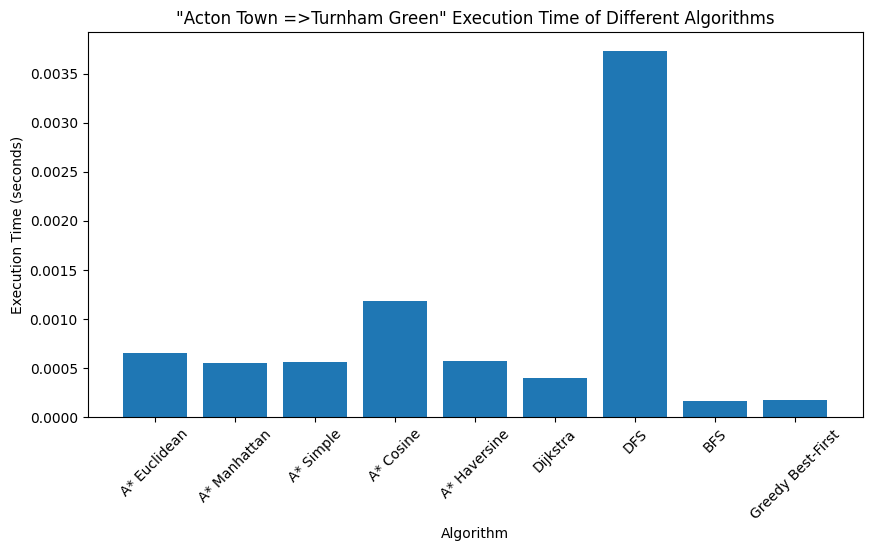

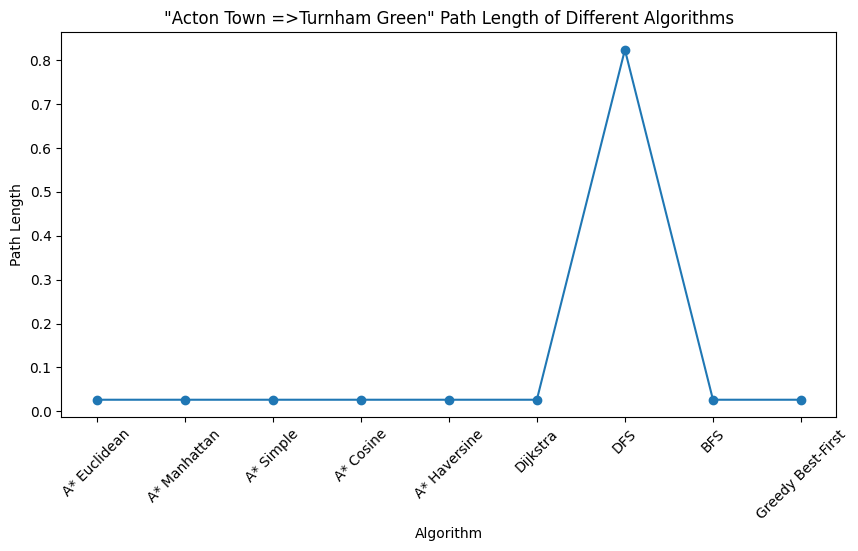

In [44]:
algorithms = ['A* Euclidean', 'A* Manhattan', 'A* Simple', 'A* Cosine', 'A* Haversine', 'Dijkstra', 'DFS', 'BFS', 'Greedy Best-First']

# 存储执行时间和路径长度的数据
execution_times = [0.0006544589996337891, 0.0005536079406738281, 0.0005583763122558594, 0.0011887550354003906, 0.0005745887756347656, 0.0004031658172607422, 0.003734111785888672, 0.0001614093780517578, 0.0001773834228515625]
path_lengths = [0.026541476974727668, 0.026541476974727668, 0.026541476974727668, 0.026541476974727668, 0.026541476974727668, 0.026541476974727668, 0.8237088434212098, 0.026541476974727668, 0.026541476974727668]

# 可视化执行时间
plt.figure(figsize=(10, 5))
plt.bar(algorithms, execution_times)
plt.xlabel('Algorithm')
plt.ylabel('Execution Time (seconds)')
plt.title('"Acton Town =>Turnham Green" Execution Time of Different Algorithms')
plt.xticks(rotation=45)
plt.show()

# 可视化路径长度
plt.figure(figsize=(10, 5))
plt.plot(algorithms, path_lengths,marker='o')
plt.xlabel('Algorithm')
plt.ylabel('Path Length')
plt.title('"Acton Town =>Turnham Green" Path Length of Different Algorithms')
plt.xticks(rotation=45)
plt.show()

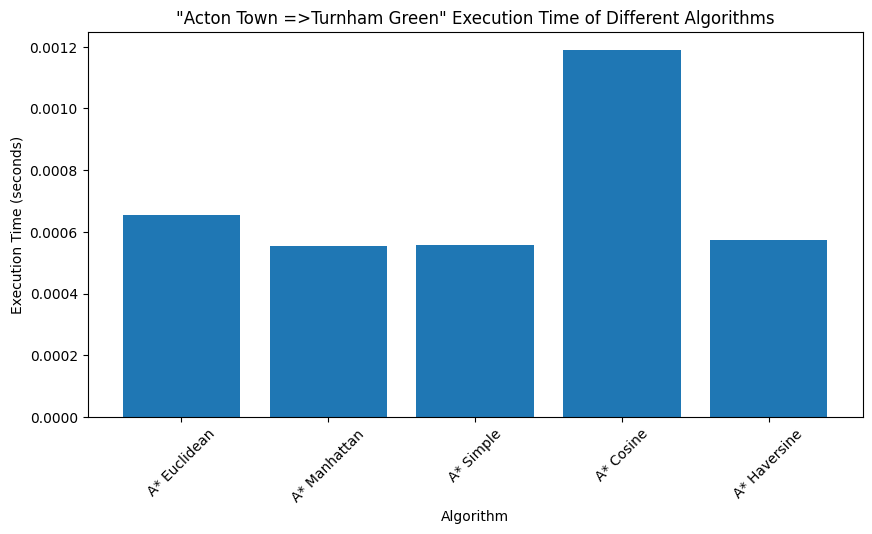

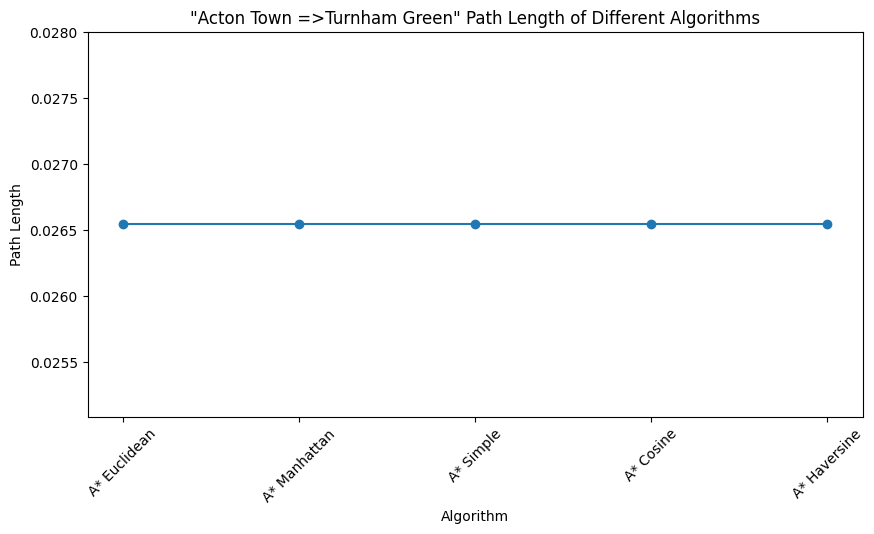

In [50]:
algorithms = ['A* Euclidean', 'A* Manhattan', 'A* Simple', 'A* Cosine', 'A* Haversine']

# Data for execution times and path lengths
execution_times = [0.0006544589996337891, 0.0005536079406738281, 0.0005583763122558594, 0.0011887550354003906, 0.0005745887756347656]
path_lengths = [0.026541476974727668, 0.026541476974727668, 0.026541476974727668, 0.026541476974727668, 0.026541476974727668]

# Visualize execution times
plt.figure(figsize=(10, 5))
plt.bar(algorithms, execution_times)
plt.xlabel('Algorithm')
plt.ylabel('Execution Time (seconds)')
plt.title('"Acton Town =>Turnham Green" Execution Time of Different Algorithms')
plt.xticks(rotation=45)
plt.show()

# Visualize path lengths
plt.figure(figsize=(10, 5))
plt.plot(algorithms, path_lengths, marker='o')
plt.xlabel('Algorithm')
plt.ylabel('Path Length')
plt.title('"Acton Town =>Turnham Green" Path Length of Different Algorithms')
plt.xticks(rotation=45)
plt.show()

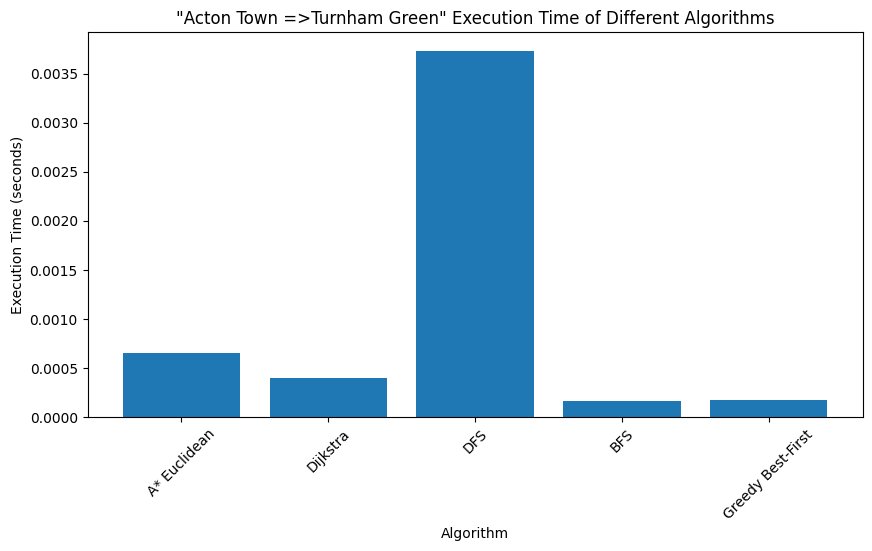

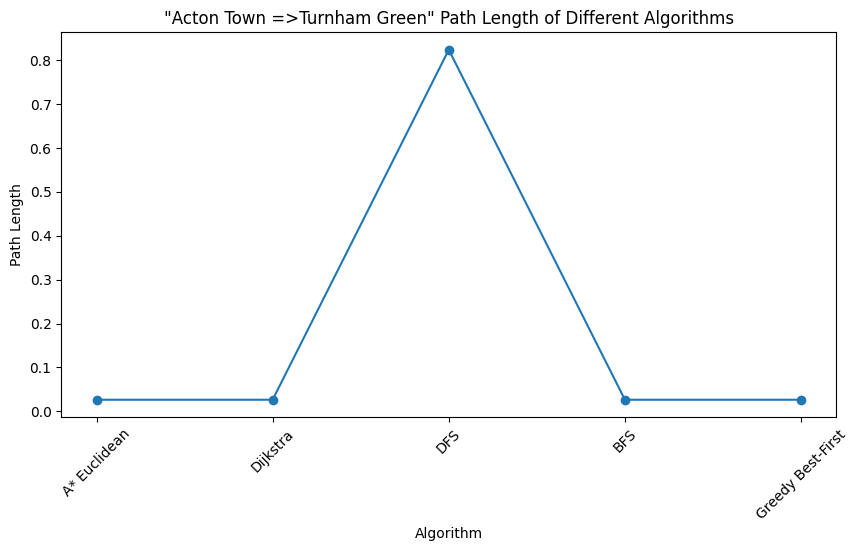

In [61]:
algorithms = ['A* Euclidean',  'Dijkstra', 'DFS', 'BFS', 'Greedy Best-First']

# 存储执行时间和路径长度的数据
execution_times = [0.0006544589996337891, 0.0004031658172607422, 0.003734111785888672, 0.0001614093780517578, 0.0001773834228515625]
path_lengths = [0.026541476974727668,  0.026541476974727668, 0.8237088434212098, 0.026541476974727668, 0.026541476974727668]

# 可视化执行时间
plt.figure(figsize=(10, 5))
plt.bar(algorithms, execution_times)
plt.xlabel('Algorithm')
plt.ylabel('Execution Time (seconds)')
plt.title('"Acton Town =>Turnham Green" Execution Time of Different Algorithms')
plt.xticks(rotation=45)
plt.show()

# 可视化路径长度
plt.figure(figsize=(10, 5))
plt.plot(algorithms, path_lengths,marker='o')
plt.xlabel('Algorithm')
plt.ylabel('Path Length')
plt.title('"Acton Town =>Turnham Green" Path Length of Different Algorithms')
plt.xticks(rotation=45)
plt.show()

# 经度差最大的站点/距离最长"Chesham=>Upminster"

In [16]:
# A* with Euclidean Distance
start_time = time.time()
path_astar_euclidean = astar_get_path("Chesham", "Upminster", stations, euclidean_distance)
end_time = time.time()
distance_astar_euclidean = calculate_total_distance(path_astar_euclidean, stations)
print("A* Euclidean Path:", path_astar_euclidean)
print("A* Euclidean Execution Time:", end_time - start_time, "seconds")
print("A* Euclidean Path Length:", distance_astar_euclidean)

# A* with Manhattan Distance
start_time = time.time()
path_astar_manhattan = astar_get_path("Chesham", "Upminster", stations, manhattan_distance)
end_time = time.time()
distance_astar_manhattan = calculate_total_distance(path_astar_manhattan, stations)
print("A* Manhattan Path:", path_astar_manhattan)
print("A* Manhattan Execution Time:", end_time - start_time, "seconds")
print("A* Manhattan Path Length:", distance_astar_manhattan)

# A* with Simple Distance
start_time = time.time()
path_astar_simple = astar_get_path("Chesham", "Upminster", stations, simple_distance)
end_time = time.time()
distance_astar_simple = calculate_total_distance(path_astar_simple, stations)
print("A* Simple Path:", path_astar_simple)
print("A* Simple Execution Time:", end_time - start_time, "seconds")
print("A* Simple Path Length:", distance_astar_simple)

# A* with Cosine Similarity Distance
start_time = time.time()
path_astar_cosine = astar_get_path("Chesham", "Upminster", stations, cosine_similarity_distance)
end_time = time.time()
distance_astar_cosine = calculate_total_distance(path_astar_cosine, stations)
print("A* Cosine Path:", path_astar_cosine)
print("A* Cosine Execution Time:", end_time - start_time, "seconds")
print("A* Cosine Path Length:", distance_astar_cosine)

# A* with Haversine Distance
start_time = time.time()
path_astar_haversine = astar_get_path("Chesham", "Upminster", stations, haversine_distance)
end_time = time.time()
distance_astar_haversine = calculate_total_distance(path_astar_haversine, stations)
print("A* Haversine Path:", path_astar_haversine)
print("A* Haversine Execution Time:", end_time - start_time, "seconds")
print("A* Haversine Path Length:", distance_astar_haversine)

# Dijkstra's Algorithm
start_time = time.time()
path_dijkstra = dijkstra_get_path("Chesham", "Upminster", stations)
end_time = time.time()
distance_dijkstra = calculate_total_distance(path_dijkstra, stations)
print("Dijkstra's Path:", path_dijkstra)
print("Dijkstra's Execution Time:", end_time - start_time, "seconds")
print("Dijkstra's Path Length:", distance_dijkstra)

# Depth-First Search (DFS)
start_time = time.time()
path_dfs = dfs_get_path("Chesham", "Upminster", stations)
end_time = time.time()
distance_dfs = calculate_total_distance(path_dfs, stations)
print("DFS Path:", path_dfs)
print("DFS Execution Time:", end_time - start_time, "seconds")
print("DFS Path Length:", distance_dfs)

# Breadth-First Search (BFS)
start_time = time.time()
path_bfs = bfs_get_path("Chesham", "Upminster", stations)
end_time = time.time()
distance_bfs = calculate_total_distance(path_bfs, stations)
print("BFS Path:", path_bfs)
print("BFS Execution Time:", end_time - start_time, "seconds")
print("BFS Path Length:", distance_bfs)

# Greedy Best-First Search 跑不出来

A* Euclidean Path: ['Chesham', 'Chalfont & Latimer', 'Chorleywood', 'Rickmansworth', 'Moor Park', 'Northwood', 'Northwood Hills', 'Pinner', 'North Harrow', 'Harrow-on-the-Hill', 'Northwick Park', 'Preston Road', 'Wembley Park', 'Finchley Road', 'Baker Street', 'Great Portland Street', 'Euston Square', "King's Cross St. Pancras", 'Farringdon', 'Barbican', 'Moorgate', 'Liverpool Street', 'Aldgate East', 'Whitechapel', 'Stepney Green', 'Mile End', 'Bow Road', 'Bromley-By-Bow', 'West Ham', 'Plaistow', 'Upton Park', 'East Ham', 'Barking', 'Upney', 'Becontree', 'Dagenham Heathway', 'Dagenham East', 'Elm Park', 'Hornchurch', 'Upminster Bridge', 'Upminster']
A* Euclidean Execution Time: 0.000690460205078125 seconds
A* Euclidean Path Length: 0.9233380432187526
A* Manhattan Path: ['Chesham', 'Chalfont & Latimer', 'Chorleywood', 'Rickmansworth', 'Moor Park', 'Northwood', 'Northwood Hills', 'Pinner', 'North Harrow', 'Harrow-on-the-Hill', 'Northwick Park', 'Preston Road', 'Wembley Park', 'Finchley 

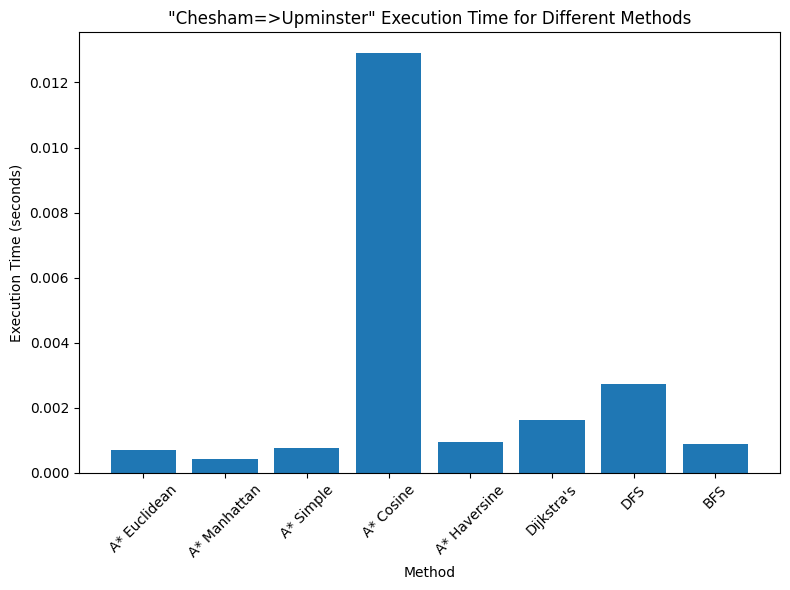

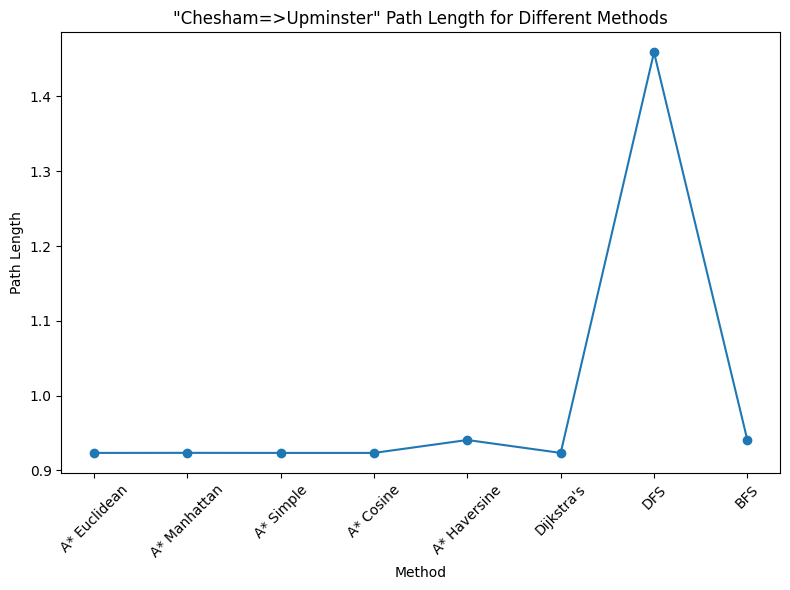

In [42]:
methods = ['A* Euclidean', 'A* Manhattan', 'A* Simple', 'A* Cosine', 'A* Haversine', "Dijkstra's", 'DFS', 'BFS']
execution_times = [0.000690460205078125, 0.0004401206970214844, 0.0007739067077636719, 0.012895822525024414, 0.0009400844573974609, 0.001641988754272461, 0.002737760543823242, 0.0008766651153564453]
path_lengths = [0.9233380432187526, 0.9234332142758988, 0.9233380432187526, 0.9233380432187526, 0.9406017778463178, 0.9233380432187526, 1.459024076741267, 0.9407087603335389]

# 可视化时间
plt.figure(figsize=(8, 6))
plt.bar(methods, execution_times)
plt.xlabel('Method')
plt.ylabel('Execution Time (seconds)')
plt.title('"Chesham=>Upminster" Execution Time for Different Methods')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 可视化路程
plt.figure(figsize=(8, 6))
plt.plot(methods, path_lengths, marker='o')
plt.xlabel('Method')
plt.ylabel('Path Length')
plt.title('"Chesham=>Upminster" Path Length for Different Methods')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

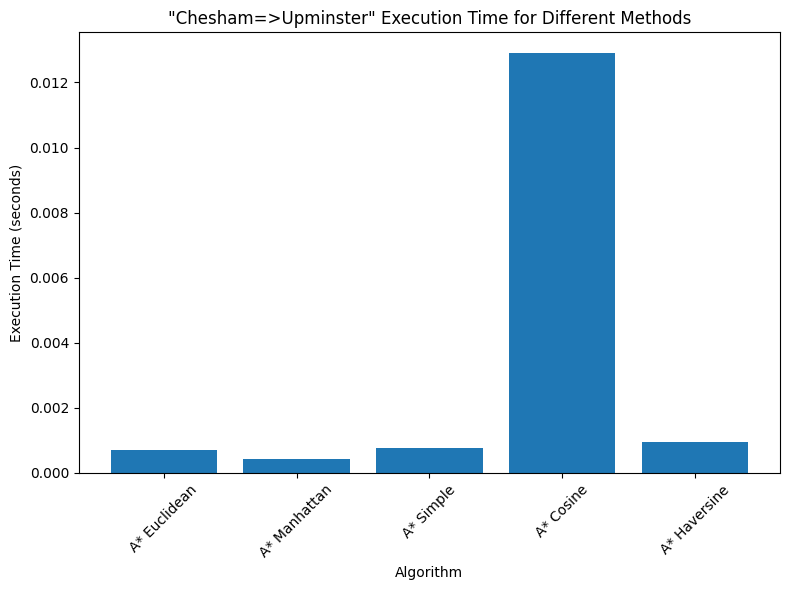

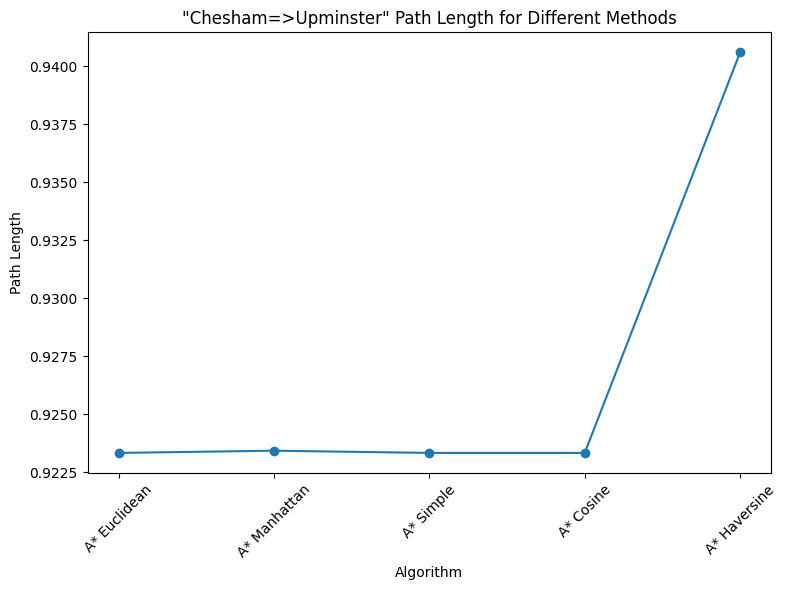

In [59]:
methods = ['A* Euclidean', 'A* Manhattan', 'A* Simple', 'A* Cosine', 'A* Haversine']

execution_times = [0.000690460205078125, 0.0004401206970214844, 0.0007739067077636719, 0.012895822525024414, 0.0009400844573974609]
path_lengths = [0.9233380432187526, 0.9234332142758988, 0.9233380432187526, 0.9233380432187526, 0.9406017778463178]

# Visualize execution times
plt.figure(figsize=(8, 6))
plt.bar(methods, execution_times)
plt.xlabel('Algorithm')
plt.ylabel('Execution Time (seconds)')
plt.title('"Chesham=>Upminster" Execution Time for Different Methods')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualize path lengths
plt.figure(figsize=(8, 6))
plt.plot(methods, path_lengths, marker='o')
plt.xlabel('Algorithm')
plt.ylabel('Path Length')
plt.title('"Chesham=>Upminster" Path Length for Different Methods')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

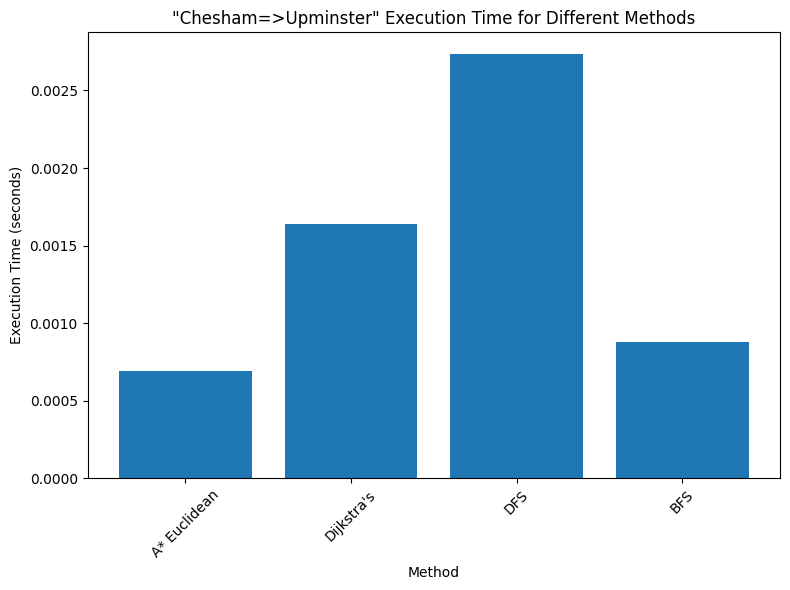

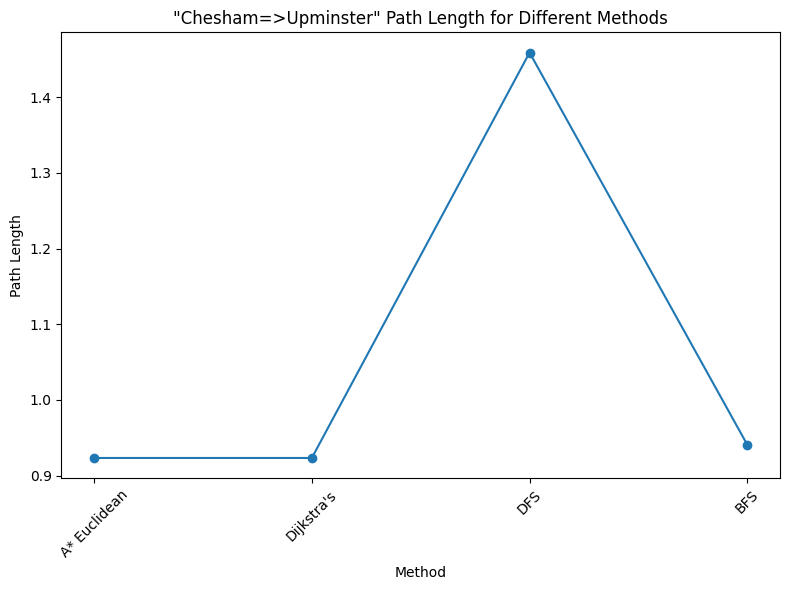

In [62]:
methods = ['A* Euclidean', "Dijkstra's", 'DFS', 'BFS']
execution_times = [0.000690460205078125, 0.001641988754272461, 0.002737760543823242, 0.0008766651153564453]
path_lengths = [0.9233380432187526,  0.9233380432187526, 1.459024076741267, 0.9407087603335389]

# 可视化时间
plt.figure(figsize=(8, 6))
plt.bar(methods, execution_times)
plt.xlabel('Method')
plt.ylabel('Execution Time (seconds)')
plt.title('"Chesham=>Upminster" Execution Time for Different Methods')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 可视化路程
plt.figure(figsize=(8, 6))
plt.plot(methods, path_lengths, marker='o')
plt.xlabel('Method')
plt.ylabel('Path Length')
plt.title('"Chesham=>Upminster" Path Length for Different Methods')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 纬度差较大且经过市中心的站点/距离较长且会经过复杂线路 "High barnet=>Morden"

In [18]:
# A* with Euclidean Distance
start_time = time.time()
path_astar_euclidean = astar_get_path("High Barnet", "Morden", stations, euclidean_distance)
end_time = time.time()
distance_astar_euclidean = calculate_total_distance(path_astar_euclidean, stations)
print("A* Euclidean Path:", path_astar_euclidean)
print("A* Euclidean Execution Time:", end_time - start_time, "seconds")
print("A* Euclidean Path Length:", distance_astar_euclidean)

# A* with Manhattan Distance
start_time = time.time()
path_astar_manhattan = astar_get_path("High Barnet", "Morden", stations, manhattan_distance)
end_time = time.time()
distance_astar_manhattan = calculate_total_distance(path_astar_manhattan, stations)
print("A* Manhattan Path:", path_astar_manhattan)
print("A* Manhattan Execution Time:", end_time - start_time, "seconds")
print("A* Manhattan Path Length:", distance_astar_manhattan)

# A* with Simple Distance
start_time = time.time()
path_astar_simple = astar_get_path("High Barnet", "Morden", stations, simple_distance)
end_time = time.time()
distance_astar_simple = calculate_total_distance(path_astar_simple, stations)
print("A* Simple Path:", path_astar_simple)
print("A* Simple Execution Time:", end_time - start_time, "seconds")
print("A* Simple Path Length:", distance_astar_simple)

# A* with Cosine Similarity Distance
start_time = time.time()
path_astar_cosine = astar_get_path("High Barnet", "Morden", stations, cosine_similarity_distance)
end_time = time.time()
distance_astar_cosine = calculate_total_distance(path_astar_cosine, stations)
print("A* Cosine Path:", path_astar_cosine)
print("A* Cosine Execution Time:", end_time - start_time, "seconds")
print("A* Cosine Path Length:", distance_astar_cosine)

# A* with Haversine Distance
start_time = time.time()
path_astar_haversine = astar_get_path("High Barnet", "Morden", stations, haversine_distance)
end_time = time.time()
distance_astar_haversine = calculate_total_distance(path_astar_haversine, stations)
print("A* Haversine Path:", path_astar_haversine)
print("A* Haversine Execution Time:", end_time - start_time, "seconds")
print("A* Haversine Path Length:", distance_astar_haversine)

# Dijkstra's Algorithm
start_time = time.time()
path_dijkstra = dijkstra_get_path("High Barnet", "Morden", stations)
end_time = time.time()
distance_dijkstra = calculate_total_distance(path_dijkstra, stations)
print("Dijkstra's Path:", path_dijkstra)
print("Dijkstra's Execution Time:", end_time - start_time, "seconds")
print("Dijkstra's Path Length:", distance_dijkstra)

# Depth-First Search (DFS)
start_time = time.time()
path_dfs = dfs_get_path("High Barnet", "Morden", stations)
end_time = time.time()
distance_dfs = calculate_total_distance(path_dfs, stations)
print("DFS Path:", path_dfs)
print("DFS Execution Time:", end_time - start_time, "seconds")
print("DFS Path Length:", distance_dfs)

# Breadth-First Search (BFS)
start_time = time.time()
path_bfs = bfs_get_path("High Barnet", "Morden", stations)
end_time = time.time()
distance_bfs = calculate_total_distance(path_bfs, stations)
print("BFS Path:", path_bfs)
print("BFS Execution Time:", end_time - start_time, "seconds")
print("BFS Path Length:", distance_bfs)

# Greedy Best-First Search 跑不出来

A* Euclidean Path: ['High Barnet', 'Totteridge & Whetstone', 'Woodside Park', 'West Finchley', 'Finchley Central', 'East Finchley', 'Highgate', 'Archway', 'Tufnell Park', 'Kentish Town', 'Camden Town', 'Euston', 'Warren Street', 'Oxford Circus', 'Green Park', 'Victoria', 'Pimlico', 'Vauxhall', 'Stockwell', 'Clapham North', 'Clapham Common', 'Clapham South', 'Balham', 'Tooting Bec', 'Tooting Broadway', 'Colliers Wood', 'South Wimbledon', 'Morden']
A* Euclidean Execution Time: 0.0005981922149658203 seconds
A* Euclidean Path Length: 0.34551186474272355
A* Manhattan Path: ['High Barnet', 'Totteridge & Whetstone', 'Woodside Park', 'West Finchley', 'Finchley Central', 'East Finchley', 'Highgate', 'Archway', 'Tufnell Park', 'Kentish Town', 'Camden Town', 'Euston', 'Warren Street', 'Oxford Circus', 'Green Park', 'Victoria', 'Pimlico', 'Vauxhall', 'Stockwell', 'Clapham North', 'Clapham Common', 'Clapham South', 'Balham', 'Tooting Bec', 'Tooting Broadway', 'Colliers Wood', 'South Wimbledon', 'Mo

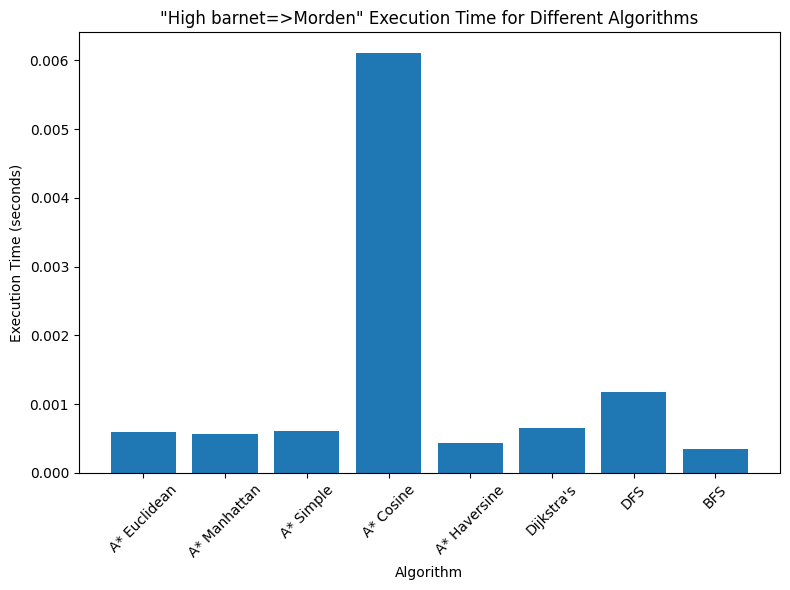

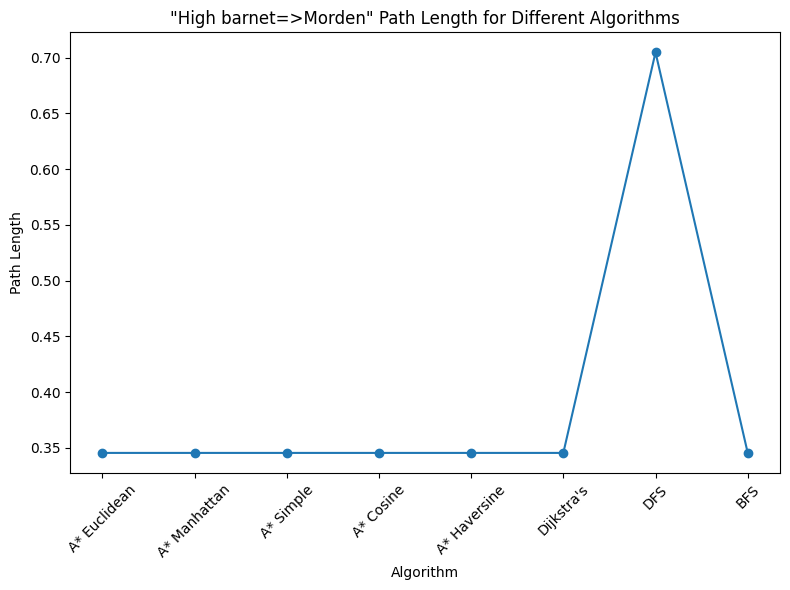

In [43]:
algorithms = ['A* Euclidean', 'A* Manhattan', 'A* Simple', 'A* Cosine', 'A* Haversine', "Dijkstra's", 'DFS', 'BFS']
execution_times = [0.0005981922149658203, 0.0005702972412109375, 0.0006113052368164062, 0.006101369857788086, 0.00043892860412597656, 0.0006532669067382812, 0.0011806488037109375, 0.00034308433532714844]
path_lengths = [0.34551186474272355, 0.34551186474272355, 0.34551186474272355, 0.34551186474272355, 0.34551186474272355, 0.34551186474272355, 0.7047297697848492, 0.34551186474272355]

# 可视化时间
plt.figure(figsize=(8, 6))
plt.bar(algorithms, execution_times)
plt.xlabel('Algorithm')
plt.ylabel('Execution Time (seconds)')
plt.title('"High barnet=>Morden" Execution Time for Different Algorithms')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 可视化路径长度
plt.figure(figsize=(8, 6))
plt.plot(algorithms, path_lengths, marker='o')
plt.xlabel('Algorithm')
plt.ylabel('Path Length')
plt.title('"High barnet=>Morden" Path Length for Different Algorithms')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

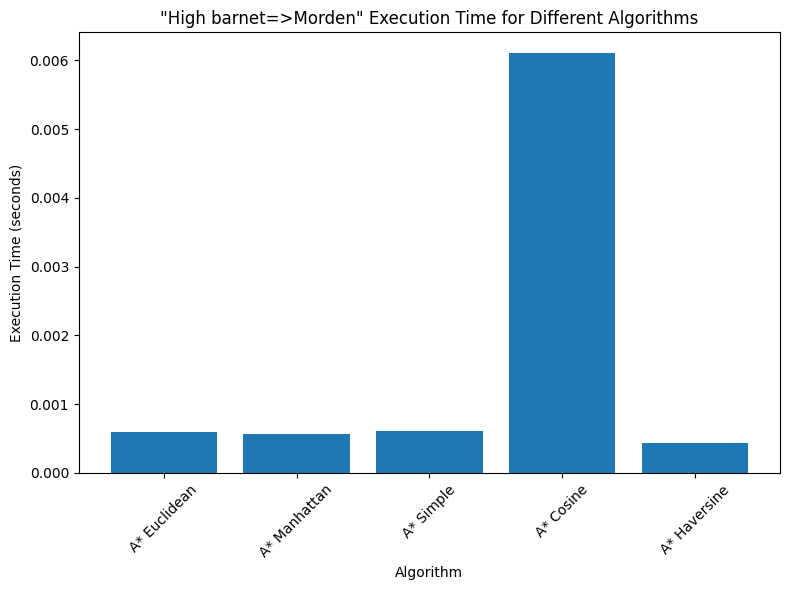

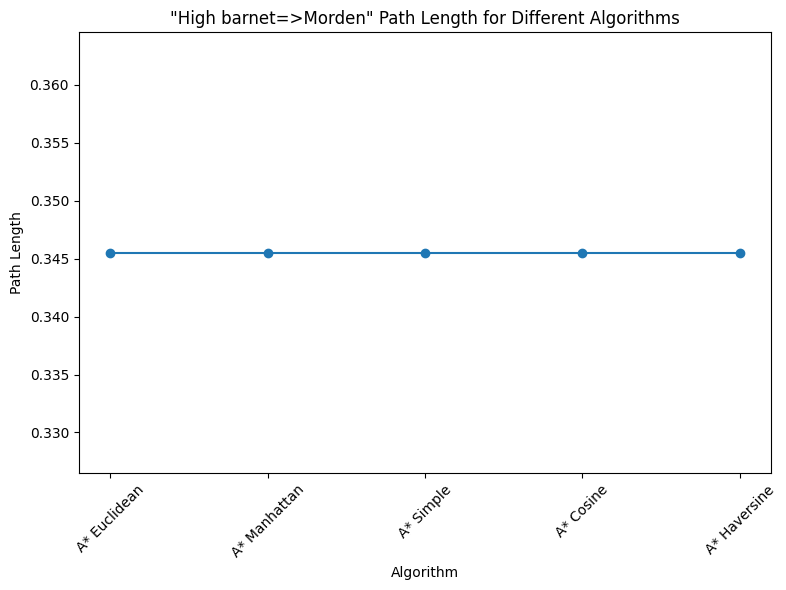

In [52]:
algorithms = ['A* Euclidean', 'A* Manhattan', 'A* Simple', 'A* Cosine', 'A* Haversine']

execution_times = [0.0005981922149658203, 0.0005702972412109375, 0.0006113052368164062, 0.006101369857788086, 0.00043892860412597656]
path_lengths = [0.34551186474272355, 0.34551186474272355, 0.34551186474272355, 0.34551186474272355, 0.34551186474272355]

# Visualize execution times
plt.figure(figsize=(8, 6))
plt.bar(algorithms, execution_times)
plt.xlabel('Algorithm')
plt.ylabel('Execution Time (seconds)')
plt.title('"High barnet=>Morden" Execution Time for Different Algorithms')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualize path lengths
plt.figure(figsize=(8, 6))
plt.plot(algorithms, path_lengths, marker='o')
plt.xlabel('Algorithm')
plt.ylabel('Path Length')
plt.title('"High barnet=>Morden" Path Length for Different Algorithms')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

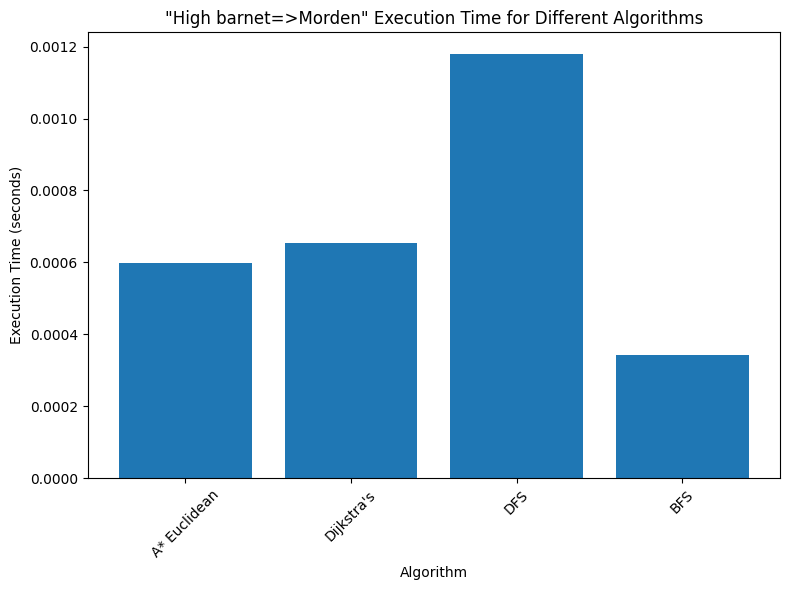

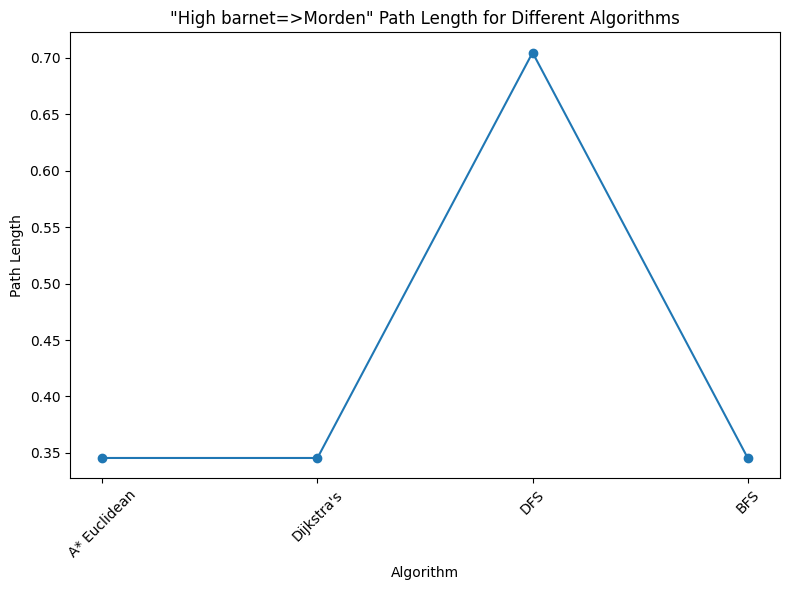

In [63]:
algorithms = ['A* Euclidean',  "Dijkstra's", 'DFS', 'BFS']
execution_times = [0.0005981922149658203,  0.0006532669067382812, 0.0011806488037109375, 0.00034308433532714844]
path_lengths = [0.34551186474272355, 0.34551186474272355, 0.7047297697848492, 0.34551186474272355]

# 可视化时间
plt.figure(figsize=(8, 6))
plt.bar(algorithms, execution_times)
plt.xlabel('Algorithm')
plt.ylabel('Execution Time (seconds)')
plt.title('"High barnet=>Morden" Execution Time for Different Algorithms')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 可视化路径长度
plt.figure(figsize=(8, 6))
plt.plot(algorithms, path_lengths, marker='o')
plt.xlabel('Algorithm')
plt.ylabel('Path Length')
plt.title('"High barnet=>Morden" Path Length for Different Algorithms')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 市中心站点/附近有不同复杂线路交叉的站点 "Tower Hill=>Marylebone"

In [14]:
# A* with Euclidean Distance
start_time = time.time()
path_astar_euclidean = astar_get_path("Tower Hill", "Marylebone", stations, euclidean_distance)
end_time = time.time()
distance_astar_euclidean = calculate_total_distance(path_astar_euclidean, stations)
print("A* Euclidean Path:", path_astar_euclidean)
print("A* Euclidean Execution Time:", end_time - start_time, "seconds")
print("A* Euclidean Path Length:", distance_astar_euclidean)

# A* with Manhattan Distance
start_time = time.time()
path_astar_manhattan = astar_get_path("Tower Hill", "Marylebone", stations, manhattan_distance)
end_time = time.time()
distance_astar_manhattan = calculate_total_distance(path_astar_manhattan, stations)
print("A* Manhattan Path:", path_astar_manhattan)
print("A* Manhattan Execution Time:", end_time - start_time, "seconds")
print("A* Manhattan Path Length:", distance_astar_manhattan)

# A* with Simple Distance
start_time = time.time()
path_astar_simple = astar_get_path("Tower Hill", "Marylebone", stations, simple_distance)
end_time = time.time()
distance_astar_simple = calculate_total_distance(path_astar_simple, stations)
print("A* Simple Path:", path_astar_simple)
print("A* Simple Execution Time:", end_time - start_time, "seconds")
print("A* Simple Path Length:", distance_astar_simple)

# A* with Cosine Similarity Distance
start_time = time.time()
path_astar_cosine = astar_get_path("Tower Hill", "Marylebone", stations, cosine_similarity_distance)
end_time = time.time()
distance_astar_cosine = calculate_total_distance(path_astar_cosine, stations)
print("A* Cosine Path:", path_astar_cosine)
print("A* Cosine Execution Time:", end_time - start_time, "seconds")
print("A* Cosine Path Length:", distance_astar_cosine)

# A* with Haversine Distance
start_time = time.time()
path_astar_haversine = astar_get_path("Tower Hill", "Marylebone", stations, haversine_distance)
end_time = time.time()
distance_astar_haversine = calculate_total_distance(path_astar_haversine, stations)
print("A* Haversine Path:", path_astar_haversine)
print("A* Haversine Execution Time:", end_time - start_time, "seconds")
print("A* Haversine Path Length:", distance_astar_haversine)

# Dijkstra's Algorithm
start_time = time.time()
path_dijkstra = dijkstra_get_path("Tower Hill", "Marylebone", stations)
end_time = time.time()
distance_dijkstra = calculate_total_distance(path_dijkstra, stations)
print("Dijkstra's Path:", path_dijkstra)
print("Dijkstra's Execution Time:", end_time - start_time, "seconds")
print("Dijkstra's Path Length:", distance_dijkstra)

# Depth-First Search (DFS)
start_time = time.time()
path_dfs = dfs_get_path("Tower Hill", "Marylebone", stations)
end_time = time.time()
distance_dfs = calculate_total_distance(path_dfs, stations)
print("DFS Path:", path_dfs)
print("DFS Execution Time:", end_time - start_time, "seconds")
print("DFS Path Length:", distance_dfs)

# Breadth-First Search (BFS)
start_time = time.time()
path_bfs = bfs_get_path("Tower Hill", "Marylebone", stations)
end_time = time.time()
distance_bfs = calculate_total_distance(path_bfs, stations)
print("BFS Path:", path_bfs)
print("BFS Execution Time:", end_time - start_time, "seconds")
print("BFS Path Length:", distance_bfs)

# Greedy Best-First Search
start_time = time.time()
path_greedy = greedy_best_first_get_path("Tower Hill", "Marylebone", stations)
end_time = time.time()
distance_greedy = calculate_total_distance(path_greedy, stations)
print("Greedy Best-First Path:", path_greedy)
print("Greedy Best-First Execution Time:", end_time - start_time, "seconds")
print("Greedy Best-First Path Length:", distance_greedy)

A* Euclidean Path: ['Tower Hill', 'Monument', 'Cannon Street', 'Mansion House', 'Blackfriars', 'Temple', 'Embankment', 'Charing Cross', 'Piccadilly Circus', 'Oxford Circus', 'Bond Street', 'Baker Street', 'Marylebone']
A* Euclidean Execution Time: 0.0002791881561279297 seconds
A* Euclidean Path Length: 0.09316964234835624
A* Manhattan Path: ['Tower Hill', 'Monument', 'Cannon Street', 'Mansion House', 'Blackfriars', 'Temple', 'Embankment', 'Charing Cross', 'Leicester Square', 'Tottenham Court Road', 'Oxford Circus', "Regent's Park", 'Baker Street', 'Marylebone']
A* Manhattan Execution Time: 0.00024056434631347656 seconds
A* Manhattan Path Length: 0.09685851250638439
A* Simple Path: ['Tower Hill', 'Monument', 'Cannon Street', 'Mansion House', 'Blackfriars', 'Temple', 'Embankment', 'Charing Cross', 'Piccadilly Circus', 'Oxford Circus', 'Bond Street', 'Baker Street', 'Marylebone']
A* Simple Execution Time: 0.0002486705780029297 seconds
A* Simple Path Length: 0.09316964234835624
A* Cosine P

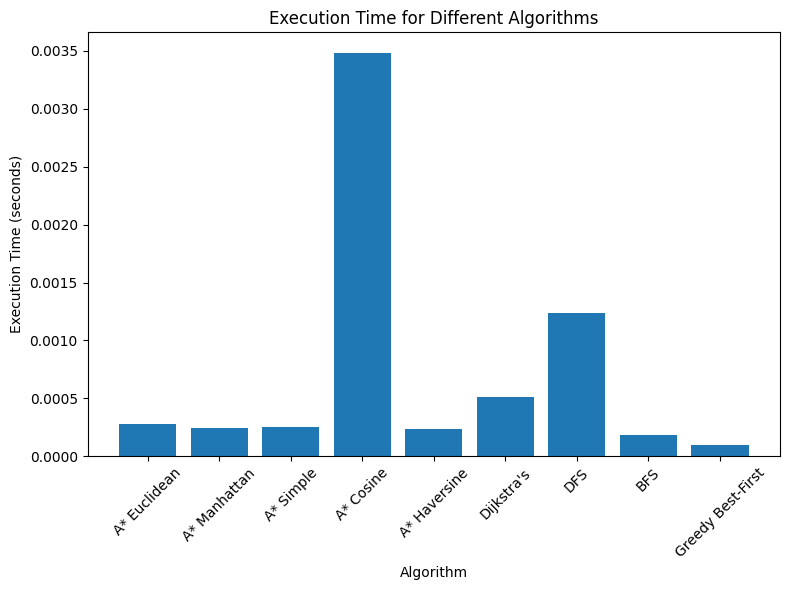

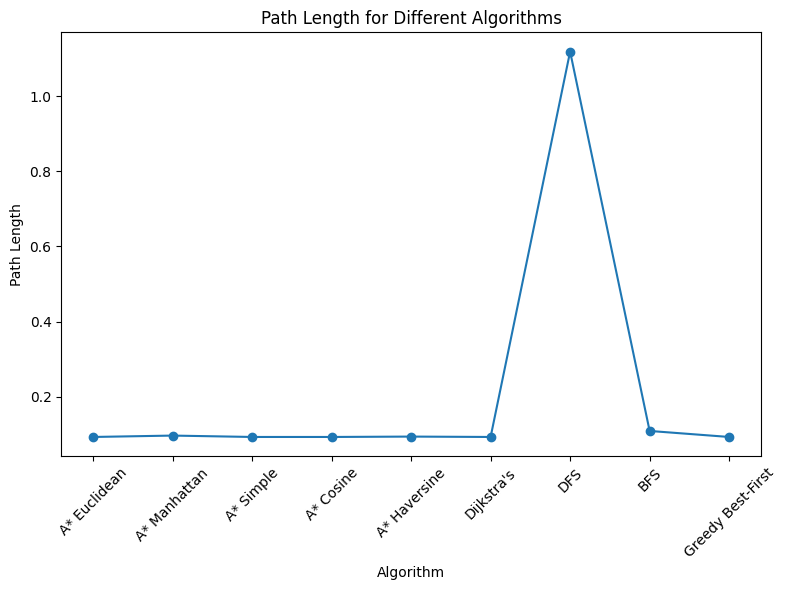

In [67]:
algorithms = ['A* Euclidean', 'A* Manhattan', 'A* Simple', 'A* Cosine', 'A* Haversine', "Dijkstra's", 'DFS', 'BFS','Greedy Best-First']
execution_times = [0.0002791881561279297, 0.00024056434631347656, 0.0002486705780029297, 0.0034868717193603516, 0.00023412704467773438, 0.0005102157592773438, 0.0012383460998535156, 0.0001842975616455078, 9.679794311523438e-05]
path_lengths = [0.09316964234835624, 0.09685851250638439, 0.09316964234835624, 0.09316964234835624, 0.09419150062104605, 0.09316964234835624, 1.1184897754824072, 0.10918284490933264, 0.09316964234835624]

# 可视化时间
plt.figure(figsize=(8, 6))
plt.bar(algorithms, execution_times)
plt.xlabel('Algorithm')
plt.ylabel('Execution Time (seconds)')
plt.title('Execution Time for Different Algorithms')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 可视化路径长度
plt.figure(figsize=(8, 6))
plt.plot(algorithms, path_lengths, marker='o')
plt.xlabel('Algorithm')
plt.ylabel('Path Length')
plt.title('Path Length for Different Algorithms')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

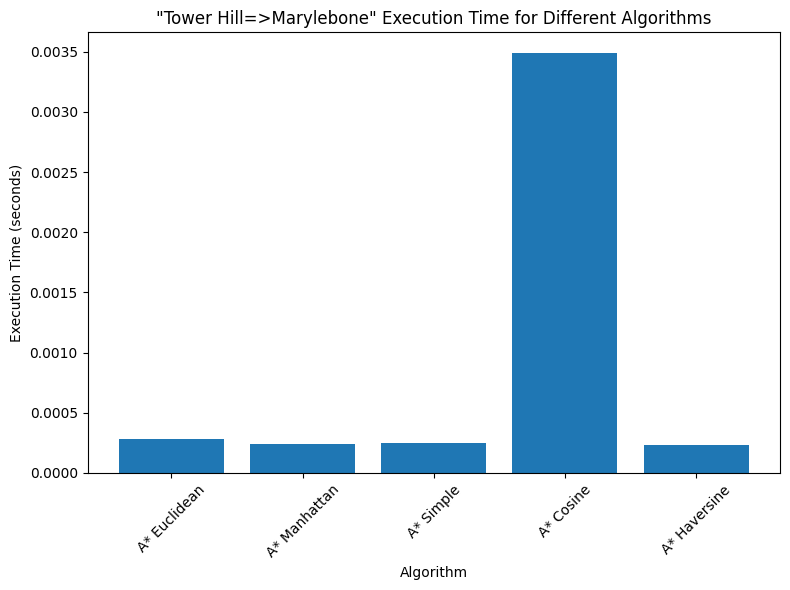

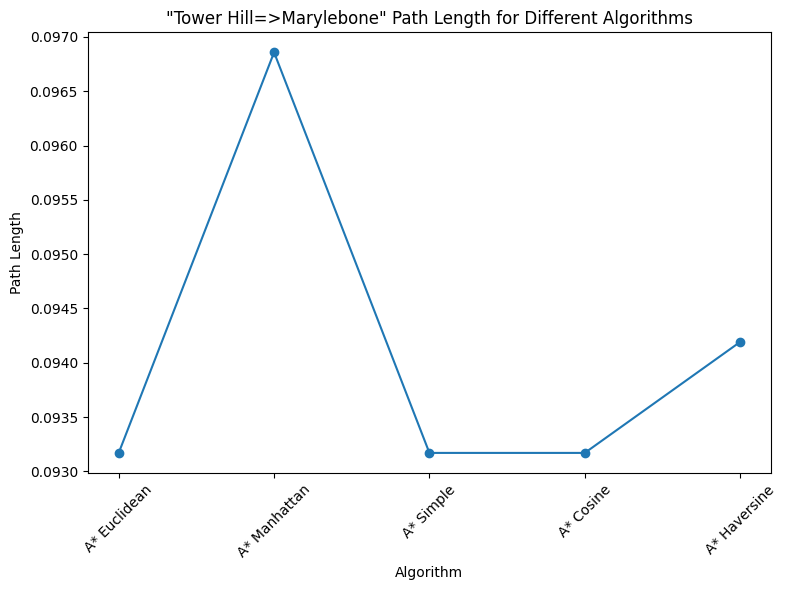

In [60]:
algorithms = ['A* Euclidean', 'A* Manhattan', 'A* Simple', 'A* Cosine', 'A* Haversine']

execution_times = [0.0002791881561279297, 0.00024056434631347656, 0.0002486705780029297, 0.0034868717193603516, 0.00023412704467773438]
path_lengths = [0.09316964234835624, 0.09685851250638439, 0.09316964234835624, 0.09316964234835624, 0.09419150062104605]

# Visualize execution times
plt.figure(figsize=(8, 6))
plt.bar(algorithms, execution_times)
plt.xlabel('Algorithm')
plt.ylabel('Execution Time (seconds)')
plt.title('"Tower Hill=>Marylebone" Execution Time for Different Algorithms')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualize path lengths
plt.figure(figsize=(8, 6))
plt.plot(algorithms, path_lengths, marker='o')
plt.xlabel('Algorithm')
plt.ylabel('Path Length')
plt.title('"Tower Hill=>Marylebone" Path Length for Different Algorithms')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

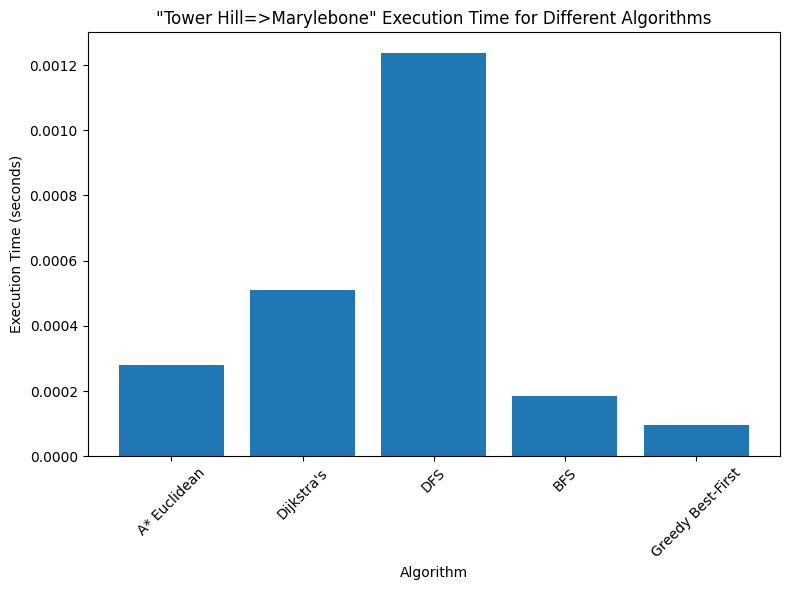

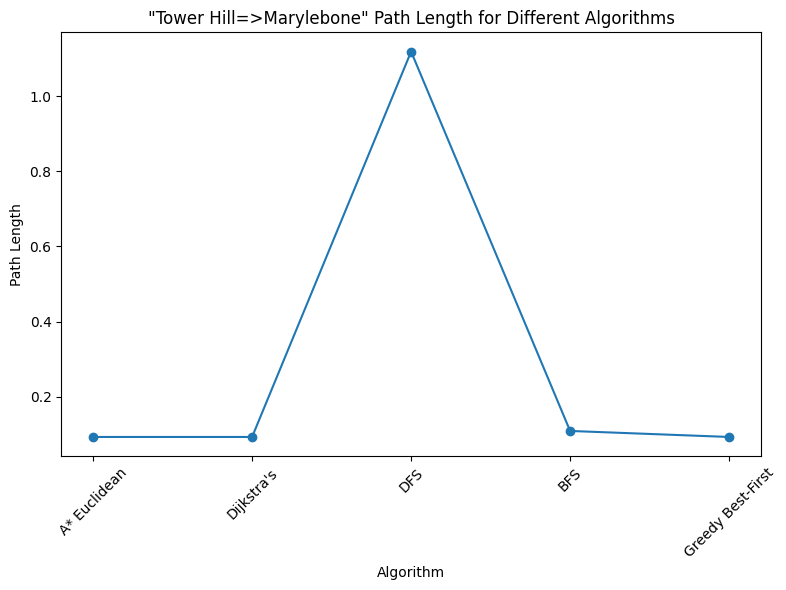

In [68]:
algorithms = ['A* Euclidean',  "Dijkstra's", 'DFS', 'BFS','Greedy Best-First']
execution_times = [0.0002791881561279297, 0.0005102157592773438, 0.0012383460998535156, 0.0001842975616455078, 9.679794311523438e-05]
path_lengths = [0.09316964234835624,  0.09316964234835624, 1.1184897754824072, 0.10918284490933264, 0.09316964234835624]

# 可视化时间
plt.figure(figsize=(8, 6))
plt.bar(algorithms, execution_times)
plt.xlabel('Algorithm')
plt.ylabel('Execution Time (seconds)')
plt.title('"Tower Hill=>Marylebone" Execution Time for Different Algorithms')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 可视化路径长度
plt.figure(figsize=(8, 6))
plt.plot(algorithms, path_lengths, marker='o')
plt.xlabel('Algorithm')
plt.ylabel('Path Length')
plt.title('"Tower Hill=>Marylebone" Path Length for Different Algorithms')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 随机选取站点并重复运行得到平均路程和时间

In [56]:
# 重复运行的次数
NUM_RUNS = 2000

# 初始化总时间和总路程
total_time_astar_euclidean = 0
total_distance_astar_euclidean = 0
total_time_astar_manhattan = 0
total_distance_astar_manhattan = 0
total_time_astar_simple = 0
total_distance_astar_simple = 0
total_time_astar_cosine = 0
total_distance_astar_cosine = 0
total_time_astar_haversine = 0
total_distance_astar_haversine = 0
total_time_dijkstra = 0
total_distance_dijkstra = 0
total_time_dfs = 0
total_distance_dfs = 0
total_time_bfs = 0
total_distance_bfs = 0
total_time_greedy = 0
total_distance_greedy = 0

# 运行50次
for _ in range(NUM_RUNS):
    # 随机生成两个站点
    station1_name, station2_name = generate_random_station_names(stations)
    
    # A* with Euclidean Distance
    start_time = time.time()
    path_astar_euclidean = astar_get_path(station1_name, station2_name, stations, euclidean_distance)
    end_time = time.time()
    distance_astar_euclidean = calculate_total_distance(path_astar_euclidean, stations)
    total_time_astar_euclidean += end_time - start_time
    total_distance_astar_euclidean += distance_astar_euclidean

    # A* with Manhattan Distance
    start_time = time.time()
    path_astar_manhattan = astar_get_path(station1_name, station2_name, stations, manhattan_distance)
    end_time = time.time()
    distance_astar_manhattan = calculate_total_distance(path_astar_manhattan, stations)
    total_time_astar_manhattan += end_time - start_time
    total_distance_astar_manhattan += distance_astar_manhattan

    # A* with Simple Distance
    start_time = time.time()
    path_astar_simple = astar_get_path(station1_name, station2_name, stations, simple_distance)
    end_time = time.time()
    distance_astar_simple = calculate_total_distance(path_astar_simple, stations)
    total_time_astar_simple += end_time - start_time
    total_distance_astar_simple += distance_astar_simple

    # A* with Cosine Similarity Distance
    start_time = time.time()
    path_astar_cosine = astar_get_path(station1_name, station2_name, stations, cosine_similarity_distance)
    end_time = time.time()
    distance_astar_cosine = calculate_total_distance(path_astar_cosine, stations)
    total_time_astar_cosine += end_time - start_time
    total_distance_astar_cosine += distance_astar_cosine

    # A* with Haversine Distance
    start_time = time.time()
    path_astar_haversine = astar_get_path(station1_name, station2_name, stations, haversine_distance)
    end_time = time.time()
    distance_astar_haversine = calculate_total_distance(path_astar_haversine, stations)
    total_time_astar_haversine += end_time - start_time
    total_distance_astar_haversine += distance_astar_haversine

    # Dijkstra's Algorithm
    start_time = time.time()
    path_dijkstra = dijkstra_get_path(station1_name, station2_name, stations)
    end_time = time.time()
    distance_dijkstra = calculate_total_distance(path_dijkstra, stations)
    total_time_dijkstra += end_time - start_time
    total_distance_dijkstra += distance_dijkstra

    # Depth-First Search (DFS)
    start_time = time.time()
    path_dfs = dfs_get_path(station1_name, station2_name, stations)
    end_time = time.time()
    distance_dfs = calculate_total_distance(path_dfs, stations)
    total_time_dfs += end_time - start_time
    total_distance_dfs += distance_dfs

    # Breadth-First Search (BFS)
    start_time = time.time()
    path_bfs = bfs_get_path(station1_name, station2_name, stations)
    end_time = time.time()
    distance_bfs = calculate_total_distance(path_bfs, stations)
    total_time_bfs += end_time - start_time
    total_distance_bfs += distance_bfs
    
    # Calculate average time and distance for each algorithm
avg_time_astar_euclidean = total_time_astar_euclidean / NUM_RUNS
avg_distance_astar_euclidean = total_distance_astar_euclidean / NUM_RUNS

avg_time_astar_manhattan = total_time_astar_manhattan / NUM_RUNS
avg_distance_astar_manhattan = total_distance_astar_manhattan / NUM_RUNS

avg_time_astar_simple = total_time_astar_simple / NUM_RUNS
avg_distance_astar_simple = total_distance_astar_simple / NUM_RUNS

avg_time_astar_cosine = total_time_astar_cosine / NUM_RUNS
avg_distance_astar_cosine = total_distance_astar_cosine / NUM_RUNS

avg_time_astar_haversine = total_time_astar_haversine / NUM_RUNS
avg_distance_astar_haversine = total_distance_astar_haversine / NUM_RUNS

avg_time_dijkstra = total_time_dijkstra / NUM_RUNS
avg_distance_dijkstra = total_distance_dijkstra / NUM_RUNS

avg_time_dfs = total_time_dfs / NUM_RUNS
avg_distance_dfs = total_distance_dfs / NUM_RUNS

avg_time_bfs = total_time_bfs / NUM_RUNS
avg_distance_bfs = total_distance_bfs / NUM_RUNS

# Create a bar chart
algorithms = [
    'A* (Euclidean)',
    'A* (Manhattan)',
    'A* (Simple)',
    'A* (Cosine)',
    'A* (Haversine)',
    'Dijkstra',
    'DFS',
    'BFS'
]

avg_times = [
    avg_time_astar_euclidean,
    avg_time_astar_manhattan,
    avg_time_astar_simple,
    avg_time_astar_cosine,
    avg_time_astar_haversine,
    avg_time_dijkstra,
    avg_time_dfs,
    avg_time_bfs
]

avg_distances = [
    avg_distance_astar_euclidean,
    avg_distance_astar_manhattan,
    avg_distance_astar_simple,
    avg_distance_astar_cosine,
    avg_distance_astar_haversine,
    avg_distance_dijkstra,
    avg_distance_dfs,
    avg_distance_bfs
]

# Print average time and distance for A* with Euclidean Distance
print("A* with Euclidean Distance:")
print("Average Time:", avg_time_astar_euclidean)
print("Average Distance:", avg_distance_astar_euclidean)
print()

# Print average time and distance for A* with Manhattan Distance
print("A* with Manhattan Distance:")
print("Average Time:", avg_time_astar_manhattan)
print("Average Distance:", avg_distance_astar_manhattan)
print()

# Print average time and distance for A* with Simple Distance
print("A* with Simple Distance:")
print("Average Time:", avg_time_astar_simple)
print("Average Distance:", avg_distance_astar_simple)
print()

# Print average time and distance for A* with Cosine Similarity Distance
print("A* with Cosine Similarity Distance:")
print("Average Time:", avg_time_astar_cosine)
print("Average Distance:", avg_distance_astar_cosine)
print()

# Print average time and distance for A* with Haversine Distance
print("A* with Haversine Distance:")
print("Average Time:", avg_time_astar_haversine)
print("Average Distance:", avg_distance_astar_haversine)
print()

# Print average time and distance for Dijkstra's Algorithm
print("Dijkstra's Algorithm:")
print("Average Time:", avg_time_dijkstra)
print("Average Distance:", avg_distance_dijkstra)
print()

# Print average time and distance for Depth-First Search (DFS)
print("Depth-First Search (DFS):")
print("Average Time:", avg_time_dfs)
print("Average Distance:", avg_distance_dfs)
print()

# Print average time and distance for Breadth-First Search (BFS)
print("Breadth-First Search (BFS):")
print("Average Time:", avg_time_bfs)
print("Average Distance:", avg_distance_bfs)
print()

A* with Euclidean Distance:
Average Time: 0.0003284121751785278
Average Distance: 0.2328153316973348

A* with Manhattan Distance:
Average Time: 0.000257543683052063
Average Distance: 0.2338220992430842

A* with Simple Distance:
Average Time: 0.0003792757987976074
Average Distance: 0.2328153316973348

A* with Cosine Similarity Distance:
Average Time: 0.002636152267456055
Average Distance: 0.2328153316973348

A* with Haversine Distance:
Average Time: 0.00023852038383483887
Average Distance: 0.24965115749416816

Dijkstra's Algorithm:
Average Time: 0.0004239382743835449
Average Distance: 0.2328153316973348

Depth-First Search (DFS):
Average Time: 0.0009157407283782959
Average Distance: 0.9560448315133735

Breadth-First Search (BFS):
Average Time: 0.00016255223751068115
Average Distance: 0.24173280104600062



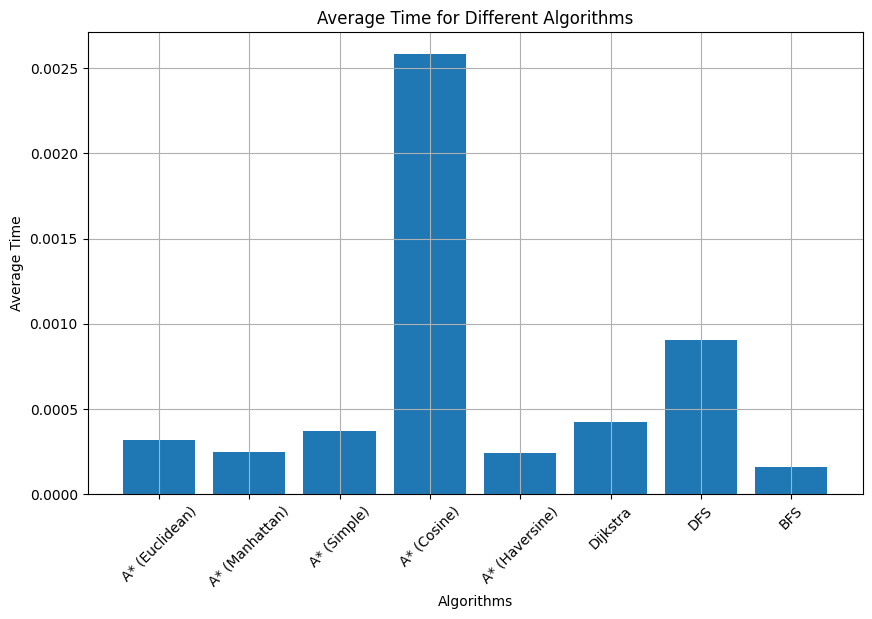

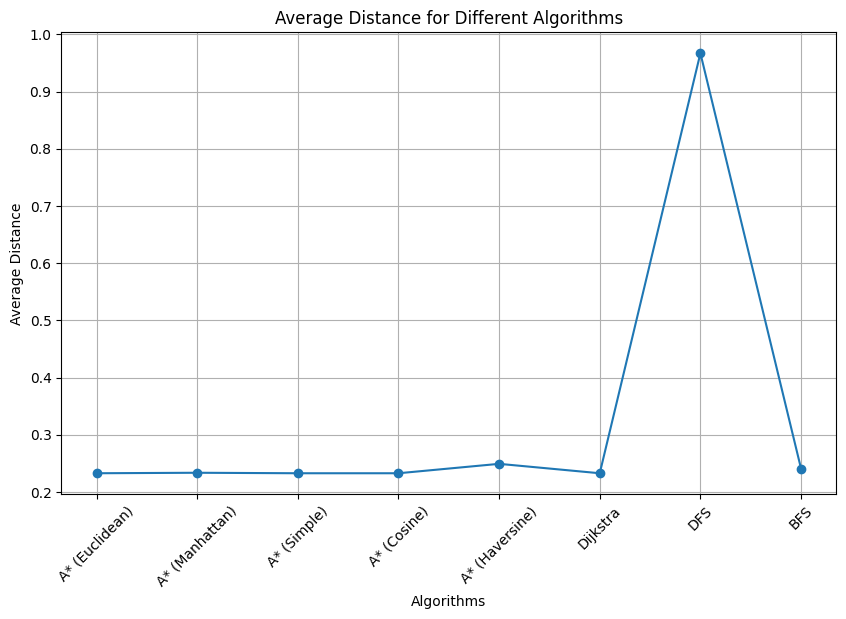

In [48]:
# Create a line plot for average times
plt.figure(figsize=(10, 6))
plt.bar(algorithms, avg_times)
plt.xlabel('Algorithms')
plt.ylabel('Average Time')
plt.title('Average Time for Different Algorithms')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Create a line plot for average distances
plt.figure(figsize=(10, 6))
plt.plot(algorithms, avg_distances, marker='o')
plt.xlabel('Algorithms')
plt.ylabel('Average Distance')
plt.title('Average Distance for Different Algorithms')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

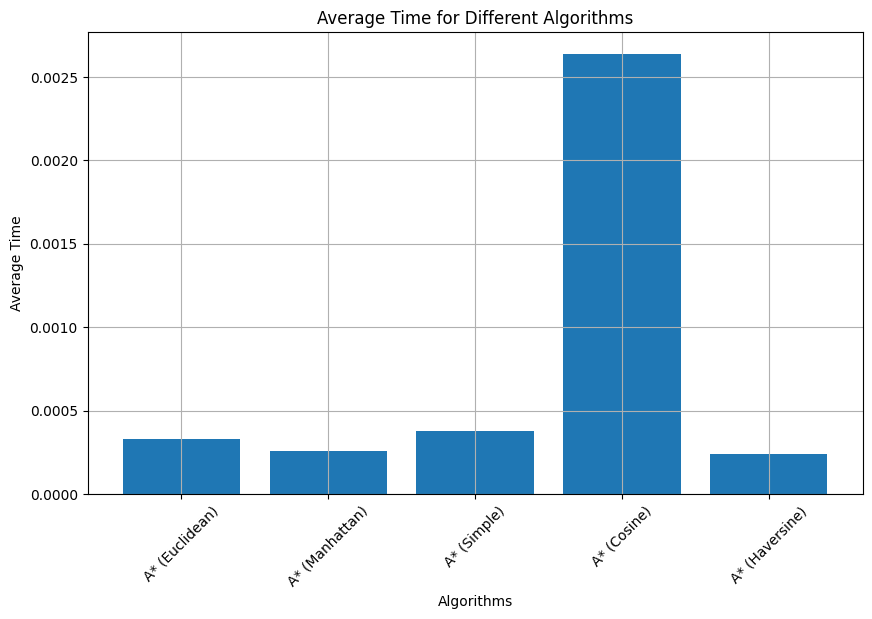

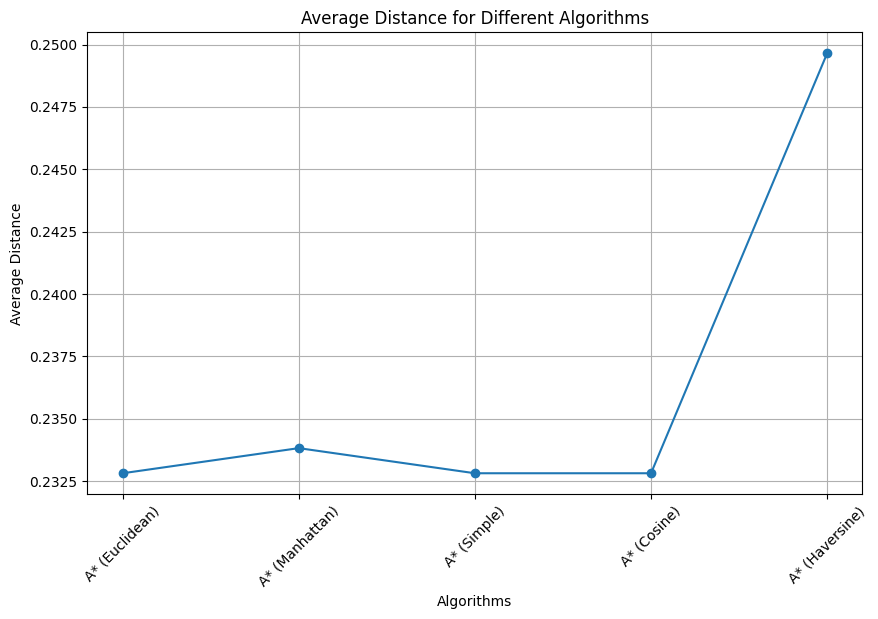

In [58]:
algorithms = [
    'A* (Euclidean)',
    'A* (Manhattan)',
    'A* (Simple)',
    'A* (Cosine)',
    'A* (Haversine)',
]
avg_times = [
    avg_time_astar_euclidean,
    avg_time_astar_manhattan,
    avg_time_astar_simple,
    avg_time_astar_cosine,
    avg_time_astar_haversine,
]

avg_distances = [
    avg_distance_astar_euclidean,
    avg_distance_astar_manhattan,
    avg_distance_astar_simple,
    avg_distance_astar_cosine,
    avg_distance_astar_haversine,
]
# Create a line plot for average times
plt.figure(figsize=(10, 6))
plt.bar(algorithms, avg_times)
plt.xlabel('Algorithms')
plt.ylabel('Average Time')
plt.title('Average Time for Different Algorithms')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Create a line plot for average distances
plt.figure(figsize=(10, 6))
plt.plot(algorithms, avg_distances, marker='o')
plt.xlabel('Algorithms')
plt.ylabel('Average Distance')
plt.title('Average Distance for Different Algorithms')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

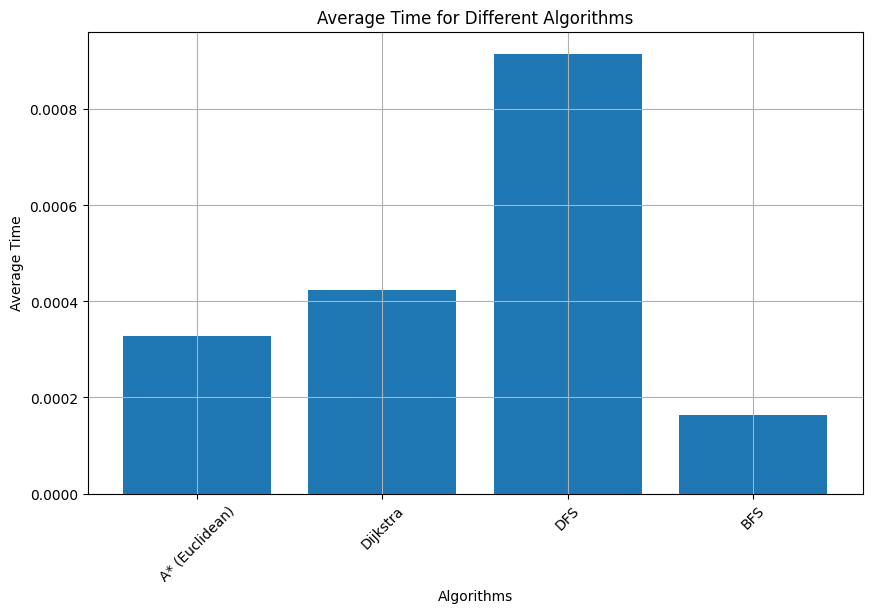

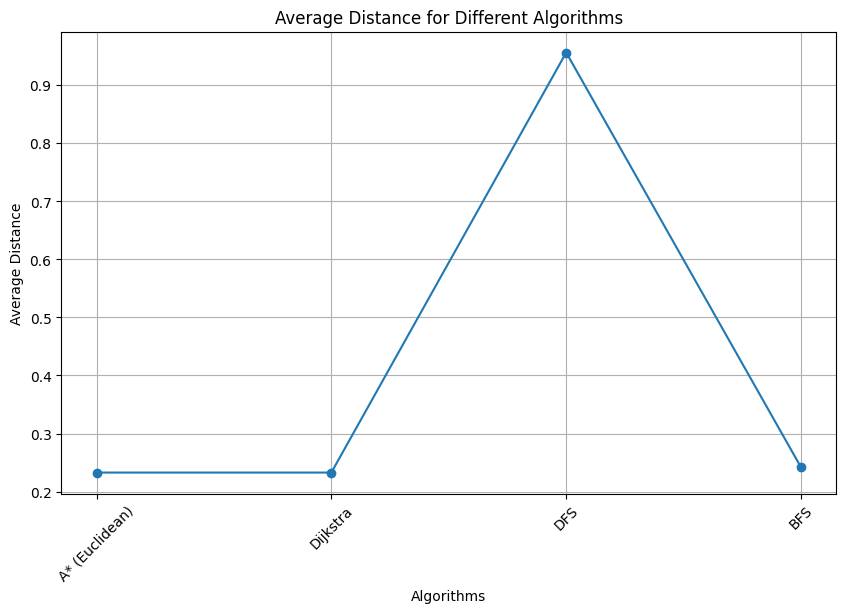

In [69]:
algorithms = [
    'A* (Euclidean)',
    'Dijkstra',
    'DFS',
    'BFS'
]

avg_times = [
    avg_time_astar_euclidean,
    avg_time_dijkstra,
    avg_time_dfs,
    avg_time_bfs
]

avg_distances = [
    avg_distance_astar_euclidean,
    avg_distance_dijkstra,
    avg_distance_dfs,
    avg_distance_bfs
]
# Create a line plot for average times
plt.figure(figsize=(10, 6))
plt.bar(algorithms, avg_times)
plt.xlabel('Algorithms')
plt.ylabel('Average Time')
plt.title('Average Time for Different Algorithms')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Create a line plot for average distances
plt.figure(figsize=(10, 6))
plt.plot(algorithms, avg_distances, marker='o')
plt.xlabel('Algorithms')
plt.ylabel('Average Distance')
plt.title('Average Distance for Different Algorithms')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [54]:
# 重复运行的次数
NUM_RUNS = 200

# 初始化总时间和总路程
total_time_astar_euclidean = 0
total_distance_astar_euclidean = 0
total_time_astar_manhattan = 0
total_distance_astar_manhattan = 0
total_time_astar_simple = 0
total_distance_astar_simple = 0
total_time_astar_cosine = 0
total_distance_astar_cosine = 0
total_time_astar_haversine = 0
total_distance_astar_haversine = 0
total_time_dijkstra = 0
total_distance_dijkstra = 0
total_time_dfs = 0
total_distance_dfs = 0
total_time_bfs = 0
total_distance_bfs = 0
total_time_greedy = 0
total_distance_greedy = 0

# 运行50次
for _ in range(NUM_RUNS):
    # 随机生成两个站点
    station1_name, station2_name = generate_random_station_names(stations)
    
    # A* with Euclidean Distance
    start_time = time.time()
    path_astar_euclidean = astar_get_path(station1_name, station2_name, stations, euclidean_distance)
    end_time = time.time()
    distance_astar_euclidean = calculate_total_distance(path_astar_euclidean, stations)
    total_time_astar_euclidean += end_time - start_time
    total_distance_astar_euclidean += distance_astar_euclidean

    # A* with Manhattan Distance
    start_time = time.time()
    path_astar_manhattan = astar_get_path(station1_name, station2_name, stations, manhattan_distance)
    end_time = time.time()
    distance_astar_manhattan = calculate_total_distance(path_astar_manhattan, stations)
    total_time_astar_manhattan += end_time - start_time
    total_distance_astar_manhattan += distance_astar_manhattan

    # A* with Simple Distance
    start_time = time.time()
    path_astar_simple = astar_get_path(station1_name, station2_name, stations, simple_distance)
    end_time = time.time()
    distance_astar_simple = calculate_total_distance(path_astar_simple, stations)
    total_time_astar_simple += end_time - start_time
    total_distance_astar_simple += distance_astar_simple

    # A* with Cosine Similarity Distance
    start_time = time.time()
    path_astar_cosine = astar_get_path(station1_name, station2_name, stations, cosine_similarity_distance)
    end_time = time.time()
    distance_astar_cosine = calculate_total_distance(path_astar_cosine, stations)
    total_time_astar_cosine += end_time - start_time
    total_distance_astar_cosine += distance_astar_cosine

    # A* with Haversine Distance
    start_time = time.time()
    path_astar_haversine = astar_get_path(station1_name, station2_name, stations, haversine_distance)
    end_time = time.time()
    distance_astar_haversine = calculate_total_distance(path_astar_haversine, stations)
    total_time_astar_haversine += end_time - start_time
    total_distance_astar_haversine += distance_astar_haversine

    # Dijkstra's Algorithm
    start_time = time.time()
    path_dijkstra = dijkstra_get_path(station1_name, station2_name, stations)
    end_time = time.time()
    distance_dijkstra = calculate_total_distance(path_dijkstra, stations)
    total_time_dijkstra += end_time - start_time
    total_distance_dijkstra += distance_dijkstra

    # Depth-First Search (DFS)
    start_time = time.time()
    path_dfs = dfs_get_path(station1_name, station2_name, stations)
    end_time = time.time()
    distance_dfs = calculate_total_distance(path_dfs, stations)
    total_time_dfs += end_time - start_time
    total_distance_dfs += distance_dfs

    # Breadth-First Search (BFS)
    start_time = time.time()
    path_bfs = bfs_get_path(station1_name, station2_name, stations)
    end_time = time.time()
    distance_bfs = calculate_total_distance(path_bfs, stations)
    total_time_bfs += end_time - start_time
    total_distance_bfs += distance_bfs
    
    # Calculate average time and distance for each algorithm
avg_time_astar_euclidean = total_time_astar_euclidean / NUM_RUNS
avg_distance_astar_euclidean = total_distance_astar_euclidean / NUM_RUNS

avg_time_astar_manhattan = total_time_astar_manhattan / NUM_RUNS
avg_distance_astar_manhattan = total_distance_astar_manhattan / NUM_RUNS

avg_time_astar_simple = total_time_astar_simple / NUM_RUNS
avg_distance_astar_simple = total_distance_astar_simple / NUM_RUNS

avg_time_astar_cosine = total_time_astar_cosine / NUM_RUNS
avg_distance_astar_cosine = total_distance_astar_cosine / NUM_RUNS

avg_time_astar_haversine = total_time_astar_haversine / NUM_RUNS
avg_distance_astar_haversine = total_distance_astar_haversine / NUM_RUNS

avg_time_dijkstra = total_time_dijkstra / NUM_RUNS
avg_distance_dijkstra = total_distance_dijkstra / NUM_RUNS

avg_time_dfs = total_time_dfs / NUM_RUNS
avg_distance_dfs = total_distance_dfs / NUM_RUNS

avg_time_bfs = total_time_bfs / NUM_RUNS
avg_distance_bfs = total_distance_bfs / NUM_RUNS

# Create a bar chart
algorithms = [
    'A* (Euclidean)',
    'A* (Manhattan)',
    'A* (Simple)',
    'A* (Cosine)',
    'A* (Haversine)',
    'Dijkstra',
    'DFS',
    'BFS'
]

avg_times = [
    avg_time_astar_euclidean,
    avg_time_astar_manhattan,
    avg_time_astar_simple,
    avg_time_astar_cosine,
    avg_time_astar_haversine,
    avg_time_dijkstra,
    avg_time_dfs,
    avg_time_bfs
]

avg_distances = [
    avg_distance_astar_euclidean,
    avg_distance_astar_manhattan,
    avg_distance_astar_simple,
    avg_distance_astar_cosine,
    avg_distance_astar_haversine,
    avg_distance_dijkstra,
    avg_distance_dfs,
    avg_distance_bfs
]

# Print average time and distance for A* with Euclidean Distance
print("A* with Euclidean Distance:")
print("Average Time:", avg_time_astar_euclidean)
print("Average Distance:", avg_distance_astar_euclidean)
print()

# Print average time and distance for A* with Manhattan Distance
print("A* with Manhattan Distance:")
print("Average Time:", avg_time_astar_manhattan)
print("Average Distance:", avg_distance_astar_manhattan)
print()

# Print average time and distance for A* with Simple Distance
print("A* with Simple Distance:")
print("Average Time:", avg_time_astar_simple)
print("Average Distance:", avg_distance_astar_simple)
print()

# Print average time and distance for A* with Cosine Similarity Distance
print("A* with Cosine Similarity Distance:")
print("Average Time:", avg_time_astar_cosine)
print("Average Distance:", avg_distance_astar_cosine)
print()

# Print average time and distance for A* with Haversine Distance
print("A* with Haversine Distance:")
print("Average Time:", avg_time_astar_haversine)
print("Average Distance:", avg_distance_astar_haversine)
print()

# Print average time and distance for Dijkstra's Algorithm
print("Dijkstra's Algorithm:")
print("Average Time:", avg_time_dijkstra)
print("Average Distance:", avg_distance_dijkstra)
print()

# Print average time and distance for Depth-First Search (DFS)
print("Depth-First Search (DFS):")
print("Average Time:", avg_time_dfs)
print("Average Distance:", avg_distance_dfs)
print()

# Print average time and distance for Breadth-First Search (BFS)
print("Breadth-First Search (BFS):")
print("Average Time:", avg_time_bfs)
print("Average Distance:", avg_distance_bfs)
print()

A* with Euclidean Distance:
Average Time: 0.0003277122974395752
Average Distance: 0.22858640166350203

A* with Manhattan Distance:
Average Time: 0.00027099013328552246
Average Distance: 0.22937785221043075

A* with Simple Distance:
Average Time: 0.00037790656089782716
Average Distance: 0.22858640166350203

A* with Cosine Similarity Distance:
Average Time: 0.002638404369354248
Average Distance: 0.22858640166350203

A* with Haversine Distance:
Average Time: 0.00024704456329345705
Average Distance: 0.24381584421944102

Dijkstra's Algorithm:
Average Time: 0.00042455792427062986
Average Distance: 0.22858640166350203

Depth-First Search (DFS):
Average Time: 0.0009168815612792968
Average Distance: 0.9559426174441917

Breadth-First Search (BFS):
Average Time: 0.00016606926918029784
Average Distance: 0.23739829200777943



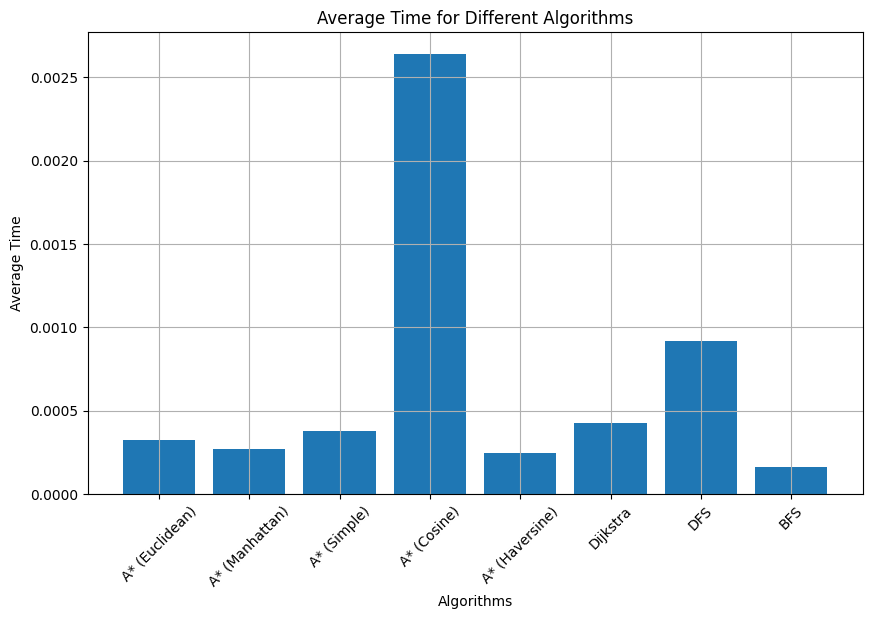

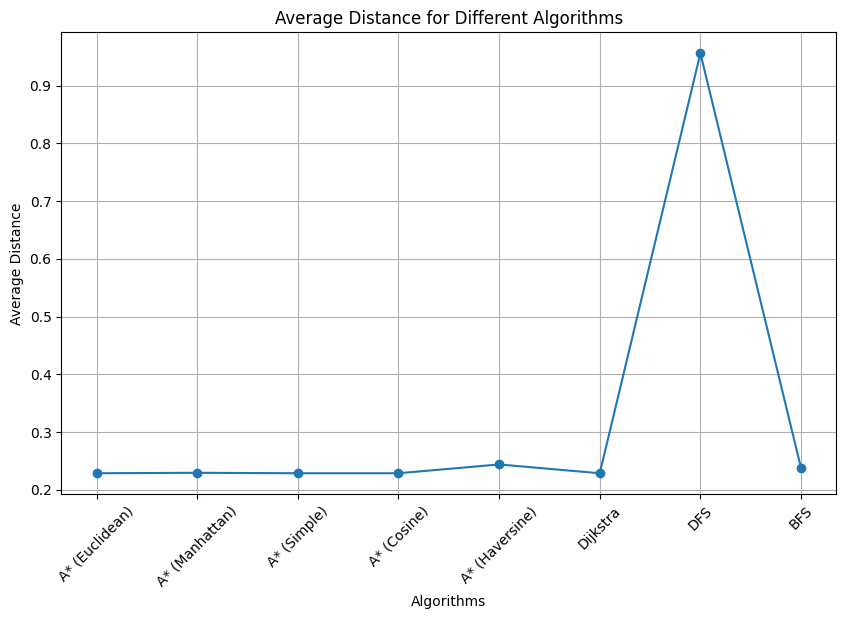

In [55]:
# Create a line plot for average times
plt.figure(figsize=(10, 6))
plt.bar(algorithms, avg_times)
plt.xlabel('Algorithms')
plt.ylabel('Average Time')
plt.title('Average Time for Different Algorithms')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Create a line plot for average distances
plt.figure(figsize=(10, 6))
plt.plot(algorithms, avg_distances, marker='o')
plt.xlabel('Algorithms')
plt.ylabel('Average Distance')
plt.title('Average Distance for Different Algorithms')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [49]:
!nvidia-smi

Thu Dec 14 10:53:41 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.113.01             Driver Version: 535.113.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A30                     On  | 00000000:65:00.0 Off |                   On |
| N/A   32C    P0              30W / 165W |                  N/A |     N/A      Default |
|                                         |                      |              Enabled |
+-----------------------------------------+----------------------+--